
#**PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS**
##**PÓS-GRADUAÇÃO LATO SENSU EM CIÊNCIA DE DADOS E BIG DATA**
###***TCC - TRABALHO DE CONCLUSÃO DE CURSO:***
###***APLICAÇÃO DE MODELOS ESTATÍSTICOS E DE APRENDIZADO DE MÁQUINA PARA A ESTIMATIVA DO PREÇO DA GASOLINA EM FUNÇÃO DE VARIÁVEIS ECONÔMICAS***
# Discente: Henrique Viegas Cunha
<hr>

#***PROJETO FUEL_PRICE: modelagem de dados LSTM***
# **Capítulo 5**
<hr>

### O presente *notebook* visa à criação de modelos de aprendizagem de máquina para a previsão do preço da gasolina em função de diversas variáveis econômicas
### O dados foram obtidos e tratados inicialmente por meio do notebook *extracao_e_tratamento_inicial.ipynb*
### A análise exploratória inicial foi realizada através do notebook *explora_dados.ipynb*
### Obs. importante: este notebook deve ser executado após o notebook *modela_dados_ARIMA_VAR.ipynb* pois possuem dados em comum
<hr> 

# Importando bibliotecas e *Montando* o Drive:
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

### Importação das bibliotecas ligadas ao ML e Keras


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential, clone_model, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Importação de bibliotecas diversas para manipulação de dados
<hr>

In [ ]:
# Bibliotecas
# Para manipulação de dados
import numpy as np
import pandas as pd
import math
import string
import os

# Atualizando para a leitura de planilha Excel
!pip install xlrd
!pip install --upgrade xlrd

# Para plotagem dos gráficos
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Para manipulação de datas
from datetime import datetime
import time
! pip install pytz
import pytz

# Selecionando o tema para os gráficos
sns.set_theme(style='ticks')

# Biblioteca de datas: datas relativas
from dateutil.relativedelta import relativedelta

# Retirando warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###*Montando* o drive do *Google* para a leitura de arquivos no Google Drive e a exportação do dataframe de trabalho
<hr>

In [ ]:
# "MONTANDO" o drive do Google Drive
# Load the Drive helper and mount (carregando)
from google.colab import drive
# This will prompt for authorization (prompt de autorização)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Definindo caminhos para compor os nomes de arquivos:
<hr>

In [ ]:
# Definindo o caminho para salvamento dos gráficos gerados
# path_fig = r'C:\\Users\\Henrique\\Documents\\TCC-PUCMG\\DADOS\\GRAFICOS\\'
path_fig = r'/content/drive/MyDrive/NOVO_TCC/DADOS/GRAFICOS/'

# Caminho onde se encontram os dataframes:
# path_backup_df = r'C:\Users\Henrique\Documents\TCC-PUCMG\DADOS\BACKUP_DF\' 
path_backup_df = r'/content/drive/MyDrive/NOVO_TCC/DADOS/BACKUP_DF/'

# Definindo o caminho para salvamento do modelo KERAS encontrado:
# path_keras_predict = r'C:\\Users\\Henrique\\Documents\\TCC-PUCMG\\DADOS\\KERAS_MODEL_PREDICT\\'
path_keras_predict = r'/content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_MODEL_PREDICT/'

# LSTM_keras_path = r'C:\Users\Henrique\Documents\TCC-PUCMG\DADOS\KERAS_LSTM_MODELS\'
LSTM_keras_path = r'/content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_LSTM_MODELS/'

# LSTM_logs_path = r'C:\Users\Henrique\Documents\TCC-PUCMG\DADOS\KERAS_LSTM_MODELS\KERAS_LOGS\'
LSTM_logs_path = r'/content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_LOGS/'

# Caminho keras mean calc:
keras_mean_path = r'/content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_MEAN_CALC/'

# Caminho keras MOVED FILES:
keras_moved_files_path = r'/content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_MOVED_FILES/'

In [ ]:
#Função para salvar o dataframe na pasta escolhida, com o nome definido:
def salva_dataframe (df, caminho_nome_completo):
  # Salvando dataframe como CSV 
  df.to_csv(caminho_nome_completo + '.csv', header=True, index=False)
  # Salvando dataframe como Excel:
  df.to_excel(caminho_nome_completo + '.xls', header=True, index=False)

# Obtendo os dados de trabalho
# Dataset de trabalho *df_trab* 
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

### O presente *notebook* visa à criação de modelos de aprendizagem de máquina para a previsão do preço da gasolina em função de diversas variáveis econômicas
### O dados foram obtidos e tratados inicialmente por meio do notebook *extracao_e_tratamento_inicial.ipynb*
### A análise exploratório inicial foi realizada através do notebook *explora_dados.ipynb*
<hr> 

### Cabe ressaltar que em nossa análise exploratória consideramos um dataframe adaptado com os valores médios mensais. Para os modelos de ML será utilizado o dataframe mais completo, com valores quase diários obtidos para as variáveis econômicas, considerando, claro, o ajuste dado por conta do tratamento dos dados

### Ainda, a coluna Fuel_Price_USD foi calculada por meio do preço da gasolina em reais (coluna Fuel_Price) e a cotação do dólar frente ao real (coluna USD/BRL). Entende-se que não é necessário manter a coluna Fuel_Price_USD para os modelos de ML, já que ela não traz nenhuma nova informação. Assim, tal coluna não será adicionada ao dataframe de trabalho
<hr> 

### O dataframe *df_final*, obtido na fase de extração e tratamento inicial,  está armazenado em formato *csv* e será importado e copiado para *df_trab*
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

In [ ]:
# Leitura do dataset de trabalho, df_final
arq_exportado = path_backup_df+'df_final.csv'
#arq_exportado = path_backup_df + 'df_final.csv'
df_trab = pd.read_csv(arq_exportado)

# Dimensões de df_trab:
print(f"\nDimensões de df_trab:\n {df_trab.shape} \n\ndf_trab.head():")

# Visualizando o dataset obtido
df_trab.head()


Dimensões de df_trab:
 (2176, 7) 

df_trab.head():


,Date,PETR4,USD/BRL,IPCA,MWh,Fuel_Price,Brent
0,2011-01-03,27.000000,1.6470,0.43,35873744,2.584085,94.84
1,2011-01-04,26.900000,1.6610,0.43,35873744,2.637004,93.53
2,2011-01-05,27.219999,1.6737,0.43,35873744,2.606665,95.50
3,2011-01-06,27.110001,1.6856,0.43,35873744,2.669766,94.52
4,2011-01-10,26.980000,1.6888,0.43,35873744,2.614946,95.70


In [ ]:
# Modificando coluna Date para tipo Datetime
df_trab['Date'] = pd.to_datetime(df_trab['Date'])

# Modificando coluna MWh para tipo float
df_trab['MWh'] = df_trab['MWh'].astype(float)

# Reindexando o dataset obtido
df_trab = df_trab.reindex(columns=['Date','Fuel_Price','USD/BRL','PETR4','Brent','IPCA','MWh'])
df_trab.head()

,Date,Fuel_Price,USD/BRL,PETR4,Brent,IPCA,MWh
0,2011-01-03,2.584085,1.6470,27.000000,94.84,0.43,35873744.0
1,2011-01-04,2.637004,1.6610,26.900000,93.53,0.43,35873744.0
2,2011-01-05,2.606665,1.6737,27.219999,95.50,0.43,35873744.0
3,2011-01-06,2.669766,1.6856,27.110001,94.52,0.43,35873744.0
4,2011-01-10,2.614946,1.6888,26.980000,95.70,0.43,35873744.0


### Criando novo dataframe de trabalho, *df_new*, cópia de *df_final*. Para uso ao longo do trabalho
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

In [ ]:
# Criando uma cópia do dataframe para uso geral:
df_new = df_trab.copy()
# Fixando a coluna Date como index da série temporal
df_new = df_new.set_index('Date')
df_new.head()

,Fuel_Price,USD/BRL,PETR4,Brent,IPCA,MWh
Date,,,,,,
2011-01-03,2.584085,1.6470,27.000000,94.84,0.43,35873744.0
2011-01-04,2.637004,1.6610,26.900000,93.53,0.43,35873744.0
2011-01-05,2.606665,1.6737,27.219999,95.50,0.43,35873744.0
2011-01-06,2.669766,1.6856,27.110001,94.52,0.43,35873744.0
2011-01-10,2.614946,1.6888,26.980000,95.70,0.43,35873744.0


# **5. Modelos Estatísticos e Machine Learning**

## **5.3. Aprendizado de Máquina**

## **5.3.1. Introdução teórica às RNN e ao LSTM**
## A introcução teórica pode ser consultada no TCC
<hr WIDTH=30% ALIGN=LEFT NOSHADE>


# **5.3.2. Long-Short Term Memory (LSTM) com *Keras***
###**(parte inicial)**
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

## A bilbioteca Keras é uma API de alto nível: para o desenvolvimento de modelos de deep learning: camadas, modelos, funções de perdas, otimizadores, métricas, e assim por diante

## Inicia-se com a recuperação dos dados de trabalho e a adequação incial do dataframe LSTM
<hr>

In [ ]:
# Copiando os dados originais para a modelagem com LSTM
df_lstm = df_new.copy()
df_lstm = df_lstm.reset_index() # Reset do index
df_lstm.rename(columns={"USD/BRL": "USD_BRL"}, inplace=True)
#df_lstm.drop(columns=['petr4', 'IPCA','MWh'], inplace=True)
print(f'Extrato de df_lstm:\n')
df_lstm.head()

Extrato de df_lstm:



,Date,Fuel_Price,USD_BRL,PETR4,Brent,IPCA,MWh
0,2011-01-03,2.584085,1.6470,27.000000,94.84,0.43,35873744.0
1,2011-01-04,2.637004,1.6610,26.900000,93.53,0.43,35873744.0
2,2011-01-05,2.606665,1.6737,27.219999,95.50,0.43,35873744.0
3,2011-01-06,2.669766,1.6856,27.110001,94.52,0.43,35873744.0
4,2011-01-10,2.614946,1.6888,26.980000,95.70,0.43,35873744.0


In [ ]:
# Salvando as datas em df separado
df_lstm_dates = pd.to_datetime(df_lstm['Date'])
# Removendo o campo de data de df_lstm:
df_lstm = df_lstm.drop(columns=['Date'])
print(f'Extrato de df_lstm (sem campo "Date"):\n')
df_lstm.head()

Extrato de df_lstm (sem campo "Date"):



,Fuel_Price,USD_BRL,PETR4,Brent,IPCA,MWh
0,2.584085,1.6470,27.000000,94.84,0.43,35873744.0
1,2.637004,1.6610,26.900000,93.53,0.43,35873744.0
2,2.606665,1.6737,27.219999,95.50,0.43,35873744.0
3,2.669766,1.6856,27.110001,94.52,0.43,35873744.0
4,2.614946,1.6888,26.980000,95.70,0.43,35873744.0


### Adequando os dados ao formato de teste: normalização, janela de previsão (inicialmente 3 dias do passado para prever um dia no futuro) e definição dos dados de treinamento, validação e teste
<hr>

In [ ]:
# Reescalonamento dos dados para uso da rede LSTM
#scaler = StandardScaler() # (média = 0, com desvio padrão igual a 1 e variância de 1)
scaler = MinMaxScaler(feature_range=(0, 1)) # Dados variando entre 0 e 1
nd_lstm_scaled = scaler.fit_transform(df_lstm.values)
print('Formato dos dados normalizados de df_lstm')
print('Obs.: já como o array "nd_lstm_scaled":')
print(nd_lstm_scaled.shape,'\n')
print('Extrato dos dados normalizados "nd_lstm_scaled":')
nd_lstm_scaled

Formato dos dados normalizados de df_lstm
Obs.: já como o array "nd_lstm_scaled":
(2176, 6) 

Extrato dos dados normalizados "nd_lstm_scaled":


array([[0.03251546, 0.02499598, 0.76819404, 0.70460322, 0.40784314,
        0.0864953 ],
       [0.04355925, 0.02821533, 0.76482476, 0.69227149, 0.40784314,
        0.0864953 ],
       [0.03722775, 0.03113574, 0.77560642, 0.71081615, 0.40784314,
        0.0864953 ],
       ...,
       [0.882867  , 0.89817647, 0.9700135 , 0.64209734, 0.69019608,
        0.88743879],
       [0.87837718, 0.89557799, 0.999663  , 0.64718065, 0.69019608,
        0.88743879],
       [0.88730705, 0.88962219, 1.        , 0.64181493, 0.69019608,
        0.88743879]])

In [ ]:
# Função para a criação de tensores de treino, validação e teste:
def cria_tensores (nd_lstm_scaled, future, past):
  # Separando X e y:
  X = []
  y = []
  
  # Colocando os dados no formato para treinamento:
  for i in range(past, nd_lstm_scaled.shape[0] - future + 1):
    X.append(nd_lstm_scaled[i - past:i, 0:nd_lstm_scaled.shape[1]])
    y.append(nd_lstm_scaled[i + future - 1:i + future, 0])
  
  # Convertendo em array
  X = np.array(X)
  y = np.array(y)

  # Forma dos dados
  print('Forma dos dados completos (tensores X, y):\n', X.shape, y.shape)
  
  # Definindo tamanho do tensores de teste e de validação:
  len_validation = round(X.shape[0]*.15)
  len_test = round(X.shape[0]*.10)

  # Definindo os tensores de treinamento:
  X_train = X[:-len_validation-len_test]
  y_train = y[:-len_validation-len_test]
  print('Forma dos dados de treino (tensores X_train, y_train):\n',
        X_train.shape, y_train.shape)
  
  # Definindo os tensores de validação:
  X_validation = X[-len_validation-len_test:-len_test]
  y_validation = y[-len_validation-len_test:-len_test]
  print('Forma dos dados de validação (tensores X_validation, y_validation):\n',
        X_validation.shape, y_validation.shape)
  
  # Definindo os tensores de teste:
  X_test = X[-len_test:]
  y_test = y[-len_test:]
  print('Forma dos dados de teste (tensores X_test, y_test):\n',
        X_test.shape, y_test.shape)
  
  return (X, y,
          X_train, y_train,
          X_validation, y_validation,
          X_test, y_test,
          len_validation, len_test)

In [ ]:
# Janela de previsão:
future = 1 # Previsão de 1 dia no futuro
past = 3 # Com base nos dados dos 3 últimos dias

# Retornando os tensores: de dados completos (X, Y); 
# de treinamento (X_train, y_train);
# de validação (X_validation, y_validation); 
# e de teste (X_test, y_test):
(X, y,
 X_train, y_train,
 X_validation, y_validation,
 X_test, y_test,
 len_validation, len_test) = cria_tensores (nd_lstm_scaled, future, past)

Forma dos dados completos (tensores X, y):
 (2173, 3, 6) (2173, 1)
Forma dos dados de treino (tensores X_train, y_train):
 (1630, 3, 6) (1630, 1)
Forma dos dados de validação (tensores X_validation, y_validation):
 (326, 3, 6) (326, 1)
Forma dos dados de teste (tensores X_test, y_test):
 (217, 3, 6) (217, 1)


# **Construindo a arquitetura da rede:**
<hr>

In [ ]:
# Arquitetura da rede: # Modelo sequencial, com adição de camadas, sendo:
# uma camada LSTM de 64 unidades, com função de ativação "relu",
# uma camada LSTM com 32 unidades, também com função de ativação "relu", 
# e, ainda, adicionando o uso da técnica de dropout com 20% de drop. 
# Como de praxe, adiciona-se uma camada final densa, sem qualquer ativação,
# para que a saída seja o "retrato" da previsão
tf.keras.backend.clear_session() # Clear model
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
model.add(LSTM(32, activation='relu',
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

# Compilando: Otimizador "RMSprop" e função de perda "mean_squared_error":
model.compile(optimizer='RMSprop', loss='mse')

# Resumo do modelo:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


### Treinando o modelo:
<hr>

In [ ]:
# Treinamento:
start_time = time.time() #Start do tempo para avaliar a demanda computacional
epocas = 120 # Definindo o número de épocas (epochs)
mini_lote = 16 # Definindo o tamanho do mini-batch
history = model.fit(X_train, y_train, 
                    epochs=epocas, 
                    batch_size=mini_lote, 
                    validation_data=(X_validation,y_validation), 
                    verbose=1)
final_time = time.time() #Tempo final para avaliar a demanda computacional
time_lstm = final_time - start_time # Tempo gasto no treinamento do modelo

Epoch 1/120
102/102 [==============================] - 4s 9ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 2/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 3/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 4/120
102/102 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 5/120
102/102 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 6/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 7/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 8/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 9/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0011 - val_lo

### Função para plotar as perdas de treinamento e validação:
<hr>

In [ ]:
# Função para a plotagem das perdas de treinamento e validação:
def plot_train_val_loss (history, time_lstm, path_fig):
  # Plotando a variação da perda em cada época: Treino x Validação:
  fig = plt.figure(figsize=(14,12))
  eixo_epocas = list(range(1,len(history.history['loss'])+1))
  plt.plot(eixo_epocas, history.history['loss'], c='slateblue', marker = '.', label='Perda do Treino')
  plt.plot(eixo_epocas, history.history['val_loss'], c='palevioletred', marker = '.', label='Perda da Validação')
  plt.title("Valores da perda - Treino x Validação\n", c='k', fontsize=13)
  plt.ylabel("Perda\n", c='k', fontsize=12)
  plt.xlabel("Épocas", c='k', fontsize=12)
  plt.figtext(0.089,0.07,f"Obs.1: janela de previsão de {past} dias", c='maroon', fontsize=10, style='italic')
  plt.figtext(0.089,0.05,f"Obs.2: tempo de treinamento de {round(time_lstm,2)} segundos", c='maroon', fontsize=10, style='italic')
  plt.legend()
  plt.xticks(rotation=0)
  
  # Salvando o gráfico/a figura gerada:
  agora = datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%d_%m_%Y_%H_%M_%S') # Tag de diferenciação das figuras salvas
  fig = plt.gcf()
  fig.savefig(path_fig+'fig_val_loss_train_loss'+agora, format='jpg')

  plt.show()

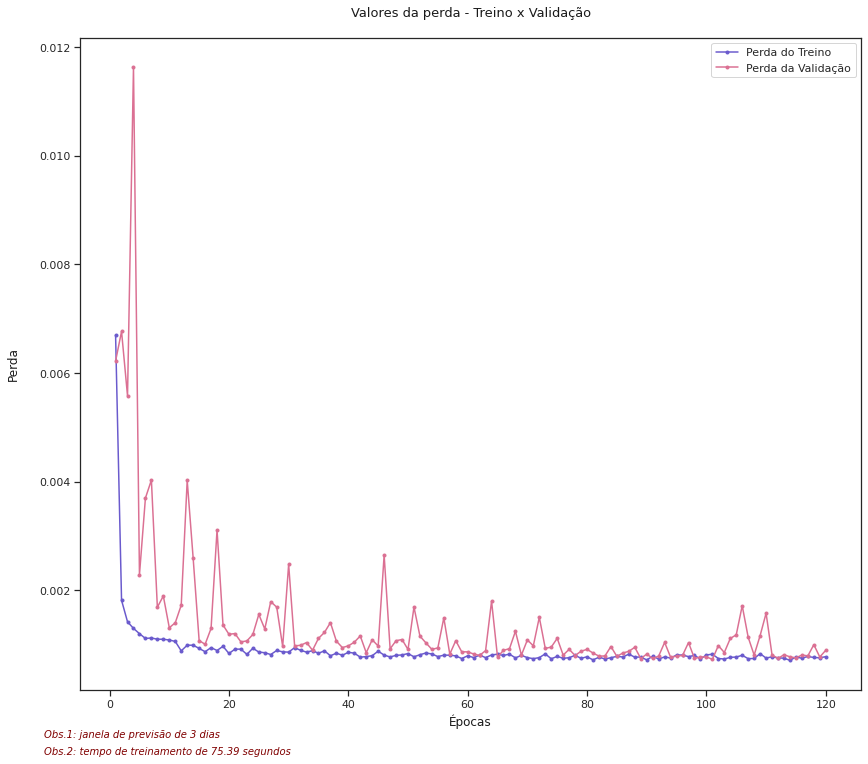

In [ ]:
# Plotando os gráficos das perdas:
plot_train_val_loss (history, time_lstm, path_fig)

### Função para o cálculo das métricas do treinamento (*RMSE*, *MAE* e *corr*): 
<hr>

In [ ]:
# Função para validação dos modelos gerados:
def validation (y_true, y_hat):
    #Calcula as seguintes métricas:
    #RMSE = Raiz do Erro Quadrático Médio
    #MAE = Erro Absoluto Médio
    #corr = Correlação de Pearson
        
    # Calculando as métricas de validação:
    rmse = np.sqrt(np.mean((y_hat - y_true)**2))
    mae = np.mean(np.abs(y_hat - y_true))
    corr = np.corrcoef(y_hat, y_true)[0,1]
    resultados = {'RMSE': rmse, 'MAE':mae, 'corr': corr}
    labels = {'RMSE': "Raiz do Erro Quadrático Médio",
              'MAE': "Erro Absoluto Médio",
              'corr': "Correlação de Pearson"}
              
    print('\n')
    # Imprimindo os resultados:
    print ("Validação do modelo por métricas estatísticas:")
    for (k, v), (w, t) in zip(resultados.items(), labels.items()):
        print(f"{t} ({k}) = {round(v,4)} ")
             
    return resultados

### Fazendo a previsão do modelo gerando as métricas do treinamento em questão:
<hr>

In [ ]:
# Previsão modelo LSTM:
forecast = model.predict(X_test, verbose=0)
forecast_copies = np.repeat(forecast, df_new.shape[1], axis=-1)
y_pred = scaler.inverse_transform(forecast_copies)[:, 0]

# Verificando as métricas:
lstm_result = validation (df_new.iloc[-len_test:,0].values, y_pred)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}")



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.5588 
Erro Absoluto Médio (MAE) = 0.522 
Correlação de Pearson (corr) = 0.9693 
Tempo de treinamento (em segundos): 75.39


###**PLOTANDO O GRÁFICO ORIGINAL x PREVISTO**
### Para melhor visualização dos valores previstos, plotam-se os valores originais do preço da gasolina x os valores previstos (relativos aos úlitmos 180 dias dos dados disponíveis, ou aproximadamente 6 meses)
<hr>

### Função para plotar os dados originais x previsão, para os últimos 180 dias:
<hr>

In [ ]:
# Função para plotagem dos dados previstos:
def plot_predict (past, df_lstm_dates, df_new, len_test, y_pred, path_fig):

  # Criando o DataFrame para plotagem dos valores previstos (do tensor de teste):
  forecast_period_dates = df_lstm_dates[-len_test:].tolist()
  df_forecast = pd.DataFrame({'Date':np.array(forecast_period_dates),'Fuel_Price':y_pred})
  df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

  # Criando o DataFrame para plotagem dos valores originais:
  df_original = df_new.copy()
  df_original = df_original.reset_index() # Reset do index
  df_original = df_original.drop(columns=['USD/BRL','PETR4','Brent','IPCA','MWh'])
  df_original = df_original.iloc[-len_test:]
  df_original.reset_index(drop=True, inplace=True) # Reset do index
  df_original['Date'] = pd.to_datetime(df_original['Date'])

  df_original = df_original.loc[len_test-180::]
  df_forecast = df_forecast.loc[len_test-180::]
  fig = plt.figure(figsize=(14,12))
  plt.figtext(0.0995,0.0615,f"Obs.1: janela de previsão de {past} dias", c='maroon', fontsize=10, style='italic')
  plt.figtext(0.0995,0.0415,f"Obs.2: dados dos últimos 180 dias coletados", c='maroon', fontsize=10, style='italic')
  sns.lineplot(df_original['Date'], df_original['Fuel_Price'], c='slateblue', label='Original', lw=1.25)
  sns.lineplot(df_forecast['Date'], df_forecast['Fuel_Price'], c='palevioletred', label='Previsto', lw=1.25)
  plt.title("\nValores de Fuel_Price - Originais x Previstos\n", c='k', fontsize=13)
  plt.ylabel("Fuel_Price\n(preço da gasolina em R$ / litro)\n", c='k', fontsize=11.5)
  plt.xlabel("\nDatas\n(obs.: dados dos últimos 180 dias coletados)", c='k', fontsize=11.5)
  plt.xlabel("\nDatas", c='k', fontsize=11.5)
  plt.legend()
  plt.xticks(rotation=0)
  
  
  # Salvando o gráfico/a figura gerada:
  agora = datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%d_%m_%Y_%H_%M_%S') # Tag de diferenciação das figuras salvas
  fig = plt.gcf()
  fig.savefig(path_fig+'fig_LSTM_real_x_previsto'+agora, format='jpg')

  plt.show()

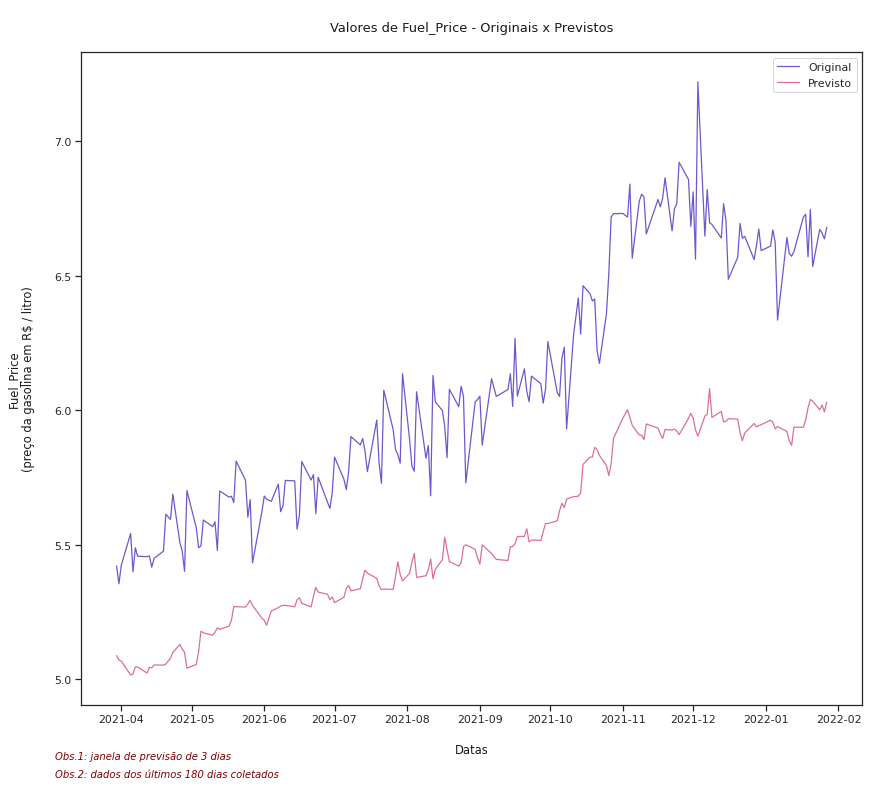

In [ ]:
# Plotando o gráfico da previsão:
plot_predict (past, df_lstm_dates, df_new, len_test,y_pred, path_fig)

# **5.3.3. Ajuste de parâmetros do modelo LSTM**
<hr WIDTH=30% ALIGN=LEFT NOSHADE>

## ***5.3.3.1 Dataframe de hiper parâmetros e métricas***
<hr>

### Como o processo de treinamento é estocástico, a cada treinamento o modelo encontrará métricas finais diferentes. Assim, vamos avaliar o modelo pela média das métricas obtidas ao longo de *n* iterações 
<hr>

In [ ]:
# Função adaptada para validação do modelo LSTM.
# Mesmos cálculos que validation, porém sem impressão dos resultados:
def validation_LSTM (y_true, y_hat):
    #Calcula as seguintes métricas:
    #RMSE = Raiz do Erro Quadrático Médio
    #MAE = Erro Absoluto Médio
    #corr = Correlação de Pearson
        
    # Calculando as métricas de validação:
    rmse = np.sqrt(np.mean((y_hat - y_true)**2))
    mae = np.mean(np.abs(y_hat - y_true))
    corr = np.corrcoef(y_hat, y_true)[0,1]
    resultados = {'RMSE': rmse, 'MAE':mae, 'corr': corr}
         
    return resultados

### Criando a lista de hiper parâmetros (*hiper_par_list*) e o dataframe para armazenar as métricas médias (*df_metricas*):
<hr>

In [ ]:
# Definindo a lista de argumentos de entrada para a função de loop:
tot_loops = 15 # Total de loops a executar
janela = past # Janela de dias para o passado
LSTM_units_1 = 64 # Número de unidades da primeira camada
LSTM_units_2 = 32 # Número de unidades da segunda camada
ativacao = 'relu' # Função de ativação das camadas LSTM
dropout_rate = 0.2 # Taxa de dropout
otimizador = 'RMSprop' # Algoritmo de otimização
perda = 'mse' # Função de perda
mini_lote = 16 # Tamanho do mini-batch
epocas = 120 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda,
                  epocas, mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]:')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]:
[15, 3, 64, 32, 'relu', 0.2, 'RMSprop', 'mse', 120, 16]


In [ ]:
# Caminho e nome definido para salvar df_metricas:
# arquivo_df_metricas = r'C:\Users\Henrique\Documents\TCC-PUCMG\DADOS\BACKUP_DF\df_metricas' 
arquivo_df_metricas = path_backup_df+'df_metricas'
# Criando o DataFrame de referência para a comparação dos modelos
df_metricas = pd.DataFrame(columns = 
                           ['Épocas', 'Tam_Mini_Batch', 'Janela',
                            'Unidades_Camada_1', 'Unidades_Camada_2',
                            'Ativação','Dropout', 'Otimizador', 'Perda',
                            'RMSE_Medio', 'MAE_Medio', 'corr_Medio', 'Tmp_Medio_Tr'])

### Função o cálculo das métricas médias após *n* iterações (*n* treinamentos):
<hr>

In [ ]:
# Criando a função para loop de aprendizado e escolha de melhor modelo
def calc_mean_metrics (hiper_par_list,
                       X_train, y_train,
                       X_validation, y_validation,
                       X_test, y_test):

  t1 = time.time() # Tempo de processamento inicial da função
  RMSE_list = [] # Criando lista RMSE
  MAE_list = [] # Criando lista MAE
  corr_list = [] # Criando lista CORR
  tempo_medio_list = [] # Criando a lista com o tempo médio de treinamento
  
  # Criando o loop para cálculo das médias:
  for i in range(hiper_par_list[0]):
    tf.keras.backend.clear_session() # Clear model
    print(f"Iteração {i+1} de {hiper_par_list[0]}... em {(time.time()-t1)/60:.2f} minutos...")
    # Arquitetura da rede:
    model = Sequential()
    if hiper_par_list[3] > 0:
      model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
      model.add(LSTM(hiper_par_list[3], activation=hiper_par_list[4],
                     return_sequences=False))
    else:
      model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                     return_sequences=False))
    model.add(Dropout(hiper_par_list[5]))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer=hiper_par_list[6], loss=hiper_par_list[7])
    # Treinamento:
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs=hiper_par_list[8],
                        batch_size=hiper_par_list[9],
                        validation_data=(X_validation,y_validation),
                        verbose=0)
    final_time = time.time()
    # Previsão:
    forecast = model.predict(X_test, verbose=0)
    forecast_copies = np.repeat(forecast, df_new.shape[1], axis=-1)
    y_pred = scaler.inverse_transform(forecast_copies)[:, 0]
    # Verificando as métricas:
    lstm_result = validation_LSTM(df_new.iloc[-len_test:,0].values, y_pred)
    # Atualizando listas de métricas:
    RMSE_list.append(lstm_result['RMSE']) 
    MAE_list.append(lstm_result['MAE'])
    corr_list.append(lstm_result['corr'])
    tempo_medio_list.append(final_time - start_time)
  
  # Criando lista para atualizar o DataFrame de métricas:
  mean_RMSE = np.mean(RMSE_list) # Média RMSE
  mean_MAE = np.mean(MAE_list) # Média MAE
  mean_corr = np.mean(corr_list) # Média corr
  mean_tempo_treino = np.mean(tempo_medio_list) # Média tempo treinamento
  t2 = time.time() # Tempo de processamento final da função
  print(f"Fim das iterações...")
  print(f"Tempo total na função: {((t2-t1)/60):.2f} minutos \n")
  
  return  mean_RMSE, mean_MAE, mean_corr, mean_tempo_treino

### Cálculando as métricas médias para a configuração inicial do modelo (arquitetura proposta inicialmente):
<hr>

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 1.01 minutos...
Iteração 3 de 15... em 2.02 minutos...
Iteração 4 de 15... em 3.04 minutos...
Iteração 5 de 15... em 4.05 minutos...
Iteração 6 de 15... em 5.08 minutos...
Iteração 7 de 15... em 6.51 minutos...
Iteração 8 de 15... em 7.54 minutos...
Iteração 9 de 15... em 8.57 minutos...
Iteração 10 de 15... em 9.60 minutos...
Iteração 11 de 15... em 11.02 minutos...
Iteração 12 de 15... em 12.44 minutos...
Iteração 13 de 15... em 13.86 minutos...
Iteração 14 de 15... em 14.89 minutos...
Iteração 15 de 15... em 15.91 minutos...
Fim das iterações...
Tempo total na função: 16.94 minutos 



### Função para a atualização de *df_metricas*:
<hr>

In [ ]:
# Função de atualização de df_metricas:
def atualiza_df_metricas (hiper_par_list, df_metricas,
                          mean_RMSE, mean_MAE, mean_corr,
                          mean_tempo_treino):
  # Lista para atualizar o dataframe de métricas:
  new_list = [hiper_par_list[8], hiper_par_list[9], hiper_par_list[1],
              hiper_par_list[2], hiper_par_list[3], hiper_par_list[4],
              hiper_par_list[5], hiper_par_list[6], hiper_par_list[7],
              mean_RMSE, mean_MAE, mean_corr, mean_tempo_treino]
  # Atualizando dataframe de métricas:
  df_new_list = pd.DataFrame([new_list], columns=df_metricas.columns)
  df_metricas_new = pd.concat([df_new_list, df_metricas], ignore_index=True)

  return df_metricas_new

In [ ]:
# Atualizando df_metricas 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)
df_metricas

,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


### Função para salvar *df_metricas*:
<hr>

### Função para plotar as perdas de treinamento e validação, bem como salvar o modelo encontrado a cada treinamento
### Obs.: facilita a plotagem das perdas, a geração da previsão e o cálculo das métricas, em cada arquitetura proposta
<hr>

In [ ]:
# Função para plotar o gráfico da evolução das perdas
# e salvar o modelo gerado a cada treinamento realizado:
def plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig):

  # Arquitetura da rede:
  tf.keras.backend.clear_session() # Clear model
  model = Sequential()
  if hiper_par_list[3] > 0:
    model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))
    model.add(LSTM(hiper_par_list[3], activation=hiper_par_list[4],
                   return_sequences=False))
  else:
    model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                   return_sequences=False))
  model.add(Dropout(hiper_par_list[5]))
  model.add(Dense(y_train.shape[1]))
  model.compile(optimizer=hiper_par_list[6], loss=hiper_par_list[7])
  # Treinamento:
  start_time = time.time() #Start do tempo para avaliar a demanda computacional
  history = model.fit(X_train, y_train,
                      epochs=hiper_par_list[8],
                      batch_size=hiper_par_list[9],
                      validation_data=(X_validation,y_validation),
                      verbose=0)
  final_time = time.time() #Tempo final para avaliar a demanda computacional
  time_lstm = final_time - start_time # Tempo gasto no treinamento do modelo
  
  # Criando o nome do modelo:
  nome_modelo = ''
  for i in hiper_par_list:
    nome_modelo = nome_modelo+'_'+str(i)
    
  # Salvando o modelo previsto para uso futuro:
  model.save(path_keras_predict+'model'+nome_modelo+'.hdf5')
  
  # Plotando os gráficos das perdas:
  plot_train_val_loss (history, time_lstm, path_fig)

  return history, time_lstm

### Função para criar o tensor com as previsões *y_pred* 
### Obs.: facilita a plotagem das perdas, a geração da previsão e o cálculo das métricas, em cada arquitetura proposta
<hr>

In [ ]:
# Função para carregar o modelo salvo e
# gerar a previsão (tesnor y_pred) e respecitvas métricas:
def func_prediction (hiper_par_list, path_keras_predict): 
  
  # Criando o nome do modelo salvo:
  nome_modelo = ''
  for i in hiper_par_list:
    nome_modelo = nome_modelo+'_'+str(i)

  # Carregando o modelo salvo:
  model = load_model (path_keras_predict+'model'+nome_modelo+'.hdf5')

  # Previsão:
  forecast = model.predict(X_test, verbose=0)
  forecast_copies = np.repeat(forecast, df_new.shape[1], axis=-1)
  y_pred = scaler.inverse_transform(forecast_copies)[:, 0]
  
  # Verificando as métricas:
  lstm_result = validation (df_new.iloc[-len_test:,0].values, y_pred)

  return y_pred

## ***5.3.3.2 Alterando o número de épocas***
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
epocas = 350 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]:')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]:
[15, 3, 64, 32, 'relu', 0.2, 'RMSprop', 'mse', 350, 16]


### Treinando o modelo novamente e plotando as perdas:
<hr>

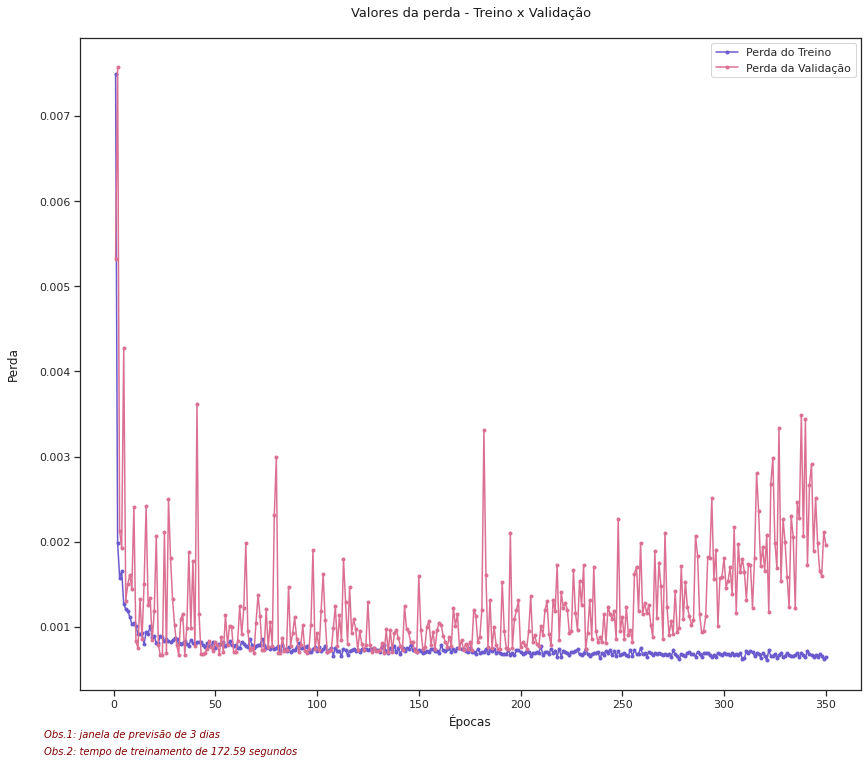

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Função para a plotagem das perdas de treinamento e validação
# limitando às épocas escolhidas:
def plot_train_val_loss_epochs (history, epocas, time_lstm, path_fig):
  # Plotando a variação da perda em cada época: Treino x Validação:
  fig = plt.figure(figsize=(14,12))
  plt.plot(history.history['loss'][:epocas], c='slateblue', marker = '.', label='Perda do Treino')
  plt.plot(history.history['val_loss'][:epocas], c='palevioletred', marker = '.', label='Perda da Validação')
  plt.title(f"Valores da perda - Treino x Validação ({epocas} épocas)\n", c='k', fontsize=13)
  plt.figtext(0.0935,0.0625,f"Obs.1: janela de previsão de {past} dias", c='maroon', fontsize=10, style='italic')
  plt.figtext(0.0935,0.0425,f"Obs.2: tempo de treinamento de {round(time_lstm,2)} segundos", c='maroon', fontsize=10, style='italic')
  plt.ylabel("Perda\n", c='k', fontsize=12)
  plt.xlabel("\nÉpocas", c='k', fontsize=12)
  plt.legend()
  plt.xticks(rotation=0)
  
  # Salvando o gráfico/a figura gerada:
  agora = datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%d_%m_%Y_%H_%M_%S') # Tag de diferenciação das figuras salvas
  fig = plt.gcf()
  fig.savefig(path_fig+f"fig_{epocas}_val_loss_train_loss_"+agora, format='jpg')

  plt.show()

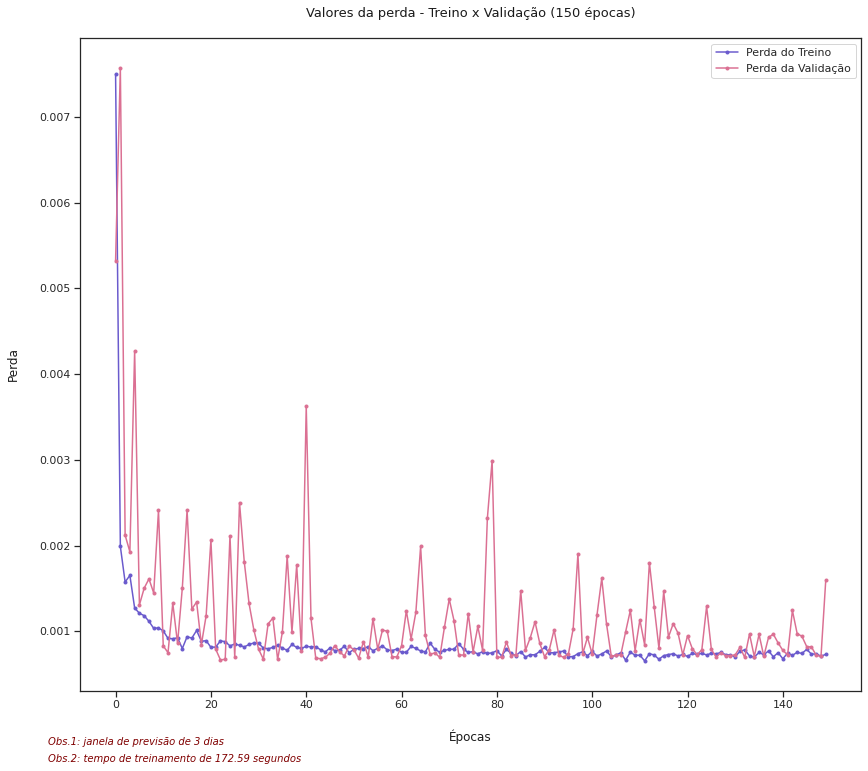

In [ ]:
# Plotando os gráficos das perdas para determinadas épocas:
plot_train_val_loss_epochs (history, 150, time_lstm, path_fig)

In [ ]:
# Ajustando a lista de hiper parâmetros:
epocas = 75 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'relu', 0.2, 'RMSprop', 'mse', 75, 16]


### Refazendo o treinamento para 75 épocas:
<hr>

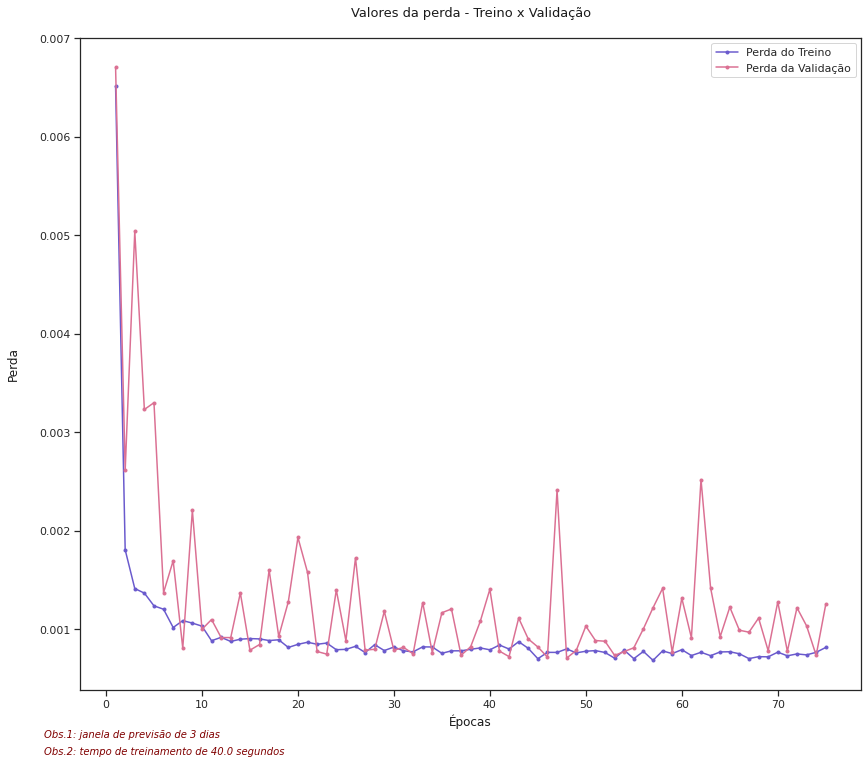

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1631 
Erro Absoluto Médio (MAE) = 0.1273 
Correlação de Pearson (corr) = 0.971 
Tempo de treinamento (em segundos): 40.0


In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.67 minutos...
Iteração 3 de 15... em 1.34 minutos...
Iteração 4 de 15... em 1.99 minutos...
Iteração 5 de 15... em 2.73 minutos...
Iteração 6 de 15... em 3.38 minutos...
Iteração 7 de 15... em 4.05 minutos...
Iteração 8 de 15... em 4.71 minutos...
Iteração 9 de 15... em 5.37 minutos...
Iteração 10 de 15... em 6.12 minutos...
Iteração 11 de 15... em 6.85 minutos...
Iteração 12 de 15... em 7.59 minutos...
Iteração 13 de 15... em 8.25 minutos...
Iteração 14 de 15... em 8.91 minutos...
Iteração 15 de 15... em 9.58 minutos...
Fim das iterações...
Tempo total na função: 10.23 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
1,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


## ***5.3.3.3. Alterando o tamanho do mini-batch***
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
mini_lote = 32 # Tamanho do mini-batch
epocas = 350 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'relu', 0.2, 'RMSprop', 'mse', 350, 32]


### Treinando o modelo com o mini-batch de 32 amostras e 350 épocas:
<hr>

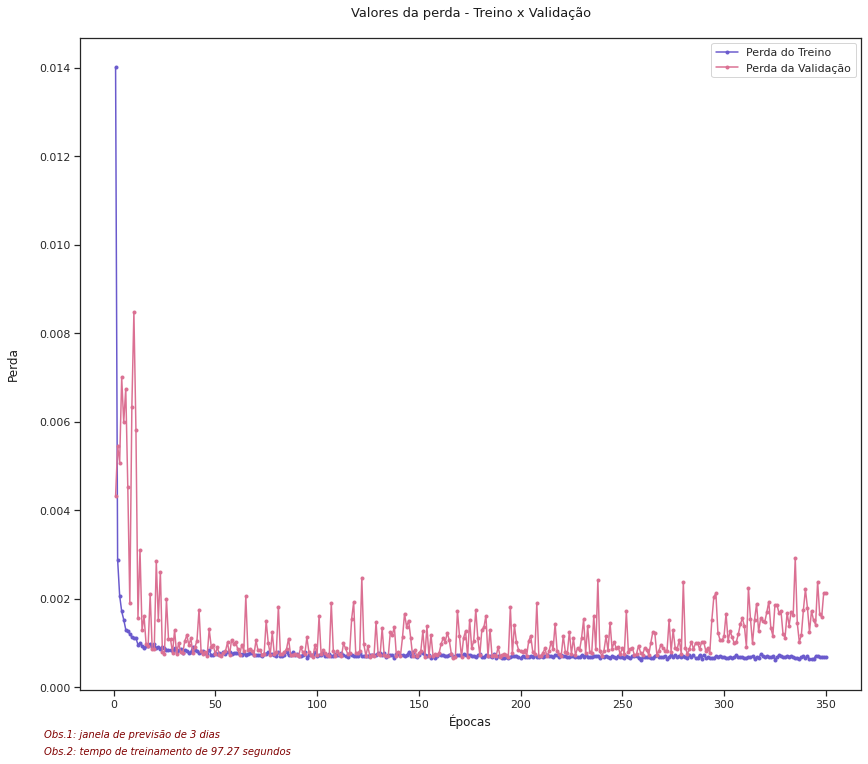

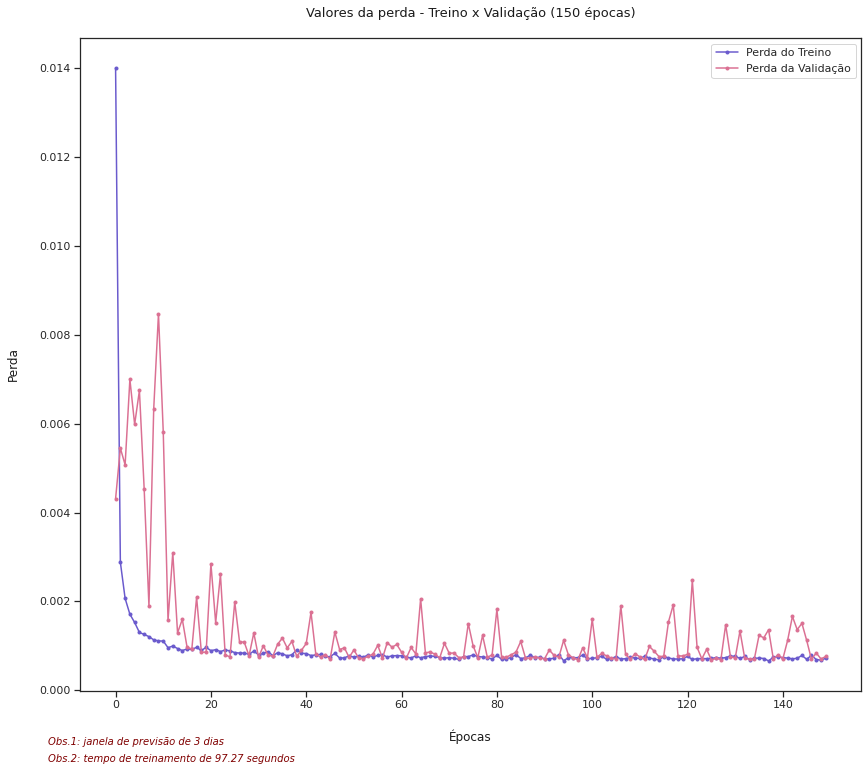

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Plotando os gráficos das perdas para determinadas épocas:
plot_train_val_loss_epochs (history, 150, time_lstm, path_fig)

### Treinando o modelo com o mini-batch de 32 amostras e 75 épocas:
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
epocas = 75 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'relu', 0.2, 'RMSprop', 'mse', 75, 32]


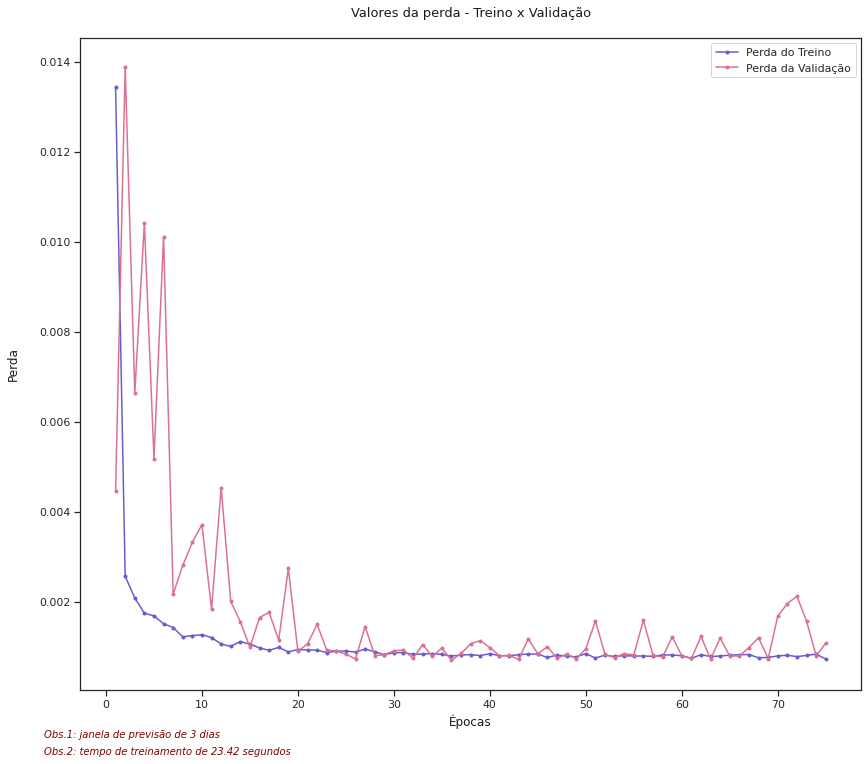



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.2201 
Erro Absoluto Médio (MAE) = 0.1845 
Correlação de Pearson (corr) = 0.9709 
Tempo de treinamento (em segundos): 23.42


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.40 minutos...
Iteração 3 de 15... em 0.81 minutos...
Iteração 4 de 15... em 1.22 minutos...
Iteração 5 de 15... em 1.95 minutos...
Iteração 6 de 15... em 2.36 minutos...
Iteração 7 de 15... em 2.76 minutos...
Iteração 8 de 15... em 3.18 minutos...
Iteração 9 de 15... em 3.59 minutos...
Iteração 10 de 15... em 4.00 minutos...
Iteração 11 de 15... em 4.74 minutos...
Iteração 12 de 15... em 5.14 minutos...
Iteração 13 de 15... em 5.88 minutos...
Iteração 14 de 15... em 6.28 minutos...
Iteração 15 de 15... em 7.03 minutos...
Fim das iterações...
Tempo total na função: 7.43 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
1,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
2,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


## ***5.3.3.4. Alterando o otimizador***
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
otimizador = 'adam' # Algoritmo de otimização
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'relu', 0.2, 'adam', 'mse', 75, 32]


### Treinando o modelo para otimizador ***adam*** (*epochs = 75 / mini-batch = 32*):
<hr>

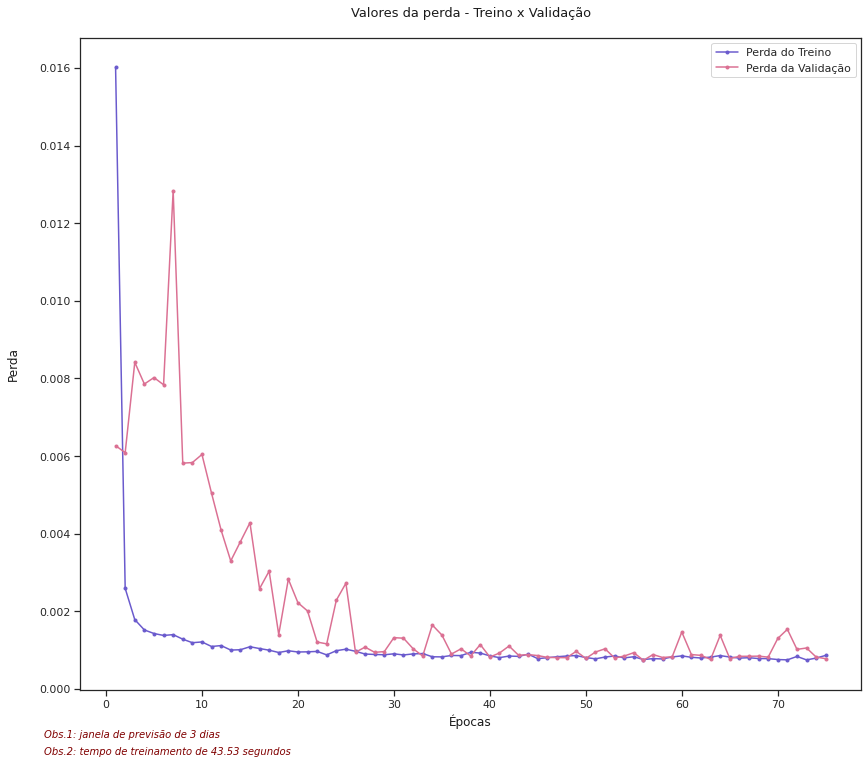



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1875 
Erro Absoluto Médio (MAE) = 0.1539 
Correlação de Pearson (corr) = 0.9689 
Tempo de treinamento (em segundos): 43.53


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.42 minutos...
Iteração 3 de 15... em 0.84 minutos...
Iteração 4 de 15... em 1.25 minutos...
Iteração 5 de 15... em 1.98 minutos...
Iteração 6 de 15... em 2.73 minutos...
Iteração 7 de 15... em 3.14 minutos...
Iteração 8 de 15... em 3.88 minutos...
Iteração 9 de 15... em 4.28 minutos...
Iteração 10 de 15... em 4.70 minutos...
Iteração 11 de 15... em 5.10 minutos...
Iteração 12 de 15... em 5.51 minutos...
Iteração 13 de 15... em 5.93 minutos...
Iteração 14 de 15... em 6.35 minutos...
Iteração 15 de 15... em 7.08 minutos...
Fim das iterações...
Tempo total na função: 7.48 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
1,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
2,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
3,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


### Métricas médias para otimizador *SGD* e *Adagrad*:
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
otimizador = 'SGD' # Algoritmo de otimização
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
 # Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.39 minutos...
Iteração 3 de 15... em 0.78 minutos...
Iteração 4 de 15... em 1.17 minutos...
Iteração 5 de 15... em 1.56 minutos...
Iteração 6 de 15... em 1.95 minutos...
Iteração 7 de 15... em 2.68 minutos...
Iteração 8 de 15... em 3.07 minutos...
Iteração 9 de 15... em 3.48 minutos...
Iteração 10 de 15... em 3.86 minutos...
Iteração 11 de 15... em 4.25 minutos...
Iteração 12 de 15... em 4.64 minutos...
Iteração 13 de 15... em 5.04 minutos...
Iteração 14 de 15... em 5.43 minutos...
Iteração 15 de 15... em 5.82 minutos...
Fim das iterações...
Tempo total na função: 6.20 minutos 



In [ ]:
# Ajustando a lista de hiper parâmetros:
otimizador = 'Adagrad' # Algoritmo de otimização
tf.keras.backend.clear_session() # Clear model
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)

# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.40 minutos...
Iteração 3 de 15... em 0.80 minutos...
Iteração 4 de 15... em 1.19 minutos...
Iteração 5 de 15... em 1.57 minutos...
Iteração 6 de 15... em 1.97 minutos...
Iteração 7 de 15... em 2.36 minutos...
Iteração 8 de 15... em 2.74 minutos...
Iteração 9 de 15... em 3.13 minutos...
Iteração 10 de 15... em 3.52 minutos...
Iteração 11 de 15... em 3.91 minutos...
Iteração 12 de 15... em 4.30 minutos...
Iteração 13 de 15... em 4.69 minutos...
Iteração 14 de 15... em 5.08 minutos...
Iteração 15 de 15... em 5.46 minutos...
Fim das iterações...
Tempo total na função: 5.85 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,relu,0.2,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
1,75,32,3,64,32,relu,0.2,SGD,mse,2.151397,2.083700,0.527686,24.203611
2,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
3,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
4,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
5,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


## ***5.3.3.5. Alterando a função de perda***
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
otimizador = 'adam' # Algoritmo de otimização
perda = 'mae' # Função de perda
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

### Treinando o modelo para função de perda *mae (mean absolut error)*
<hr>

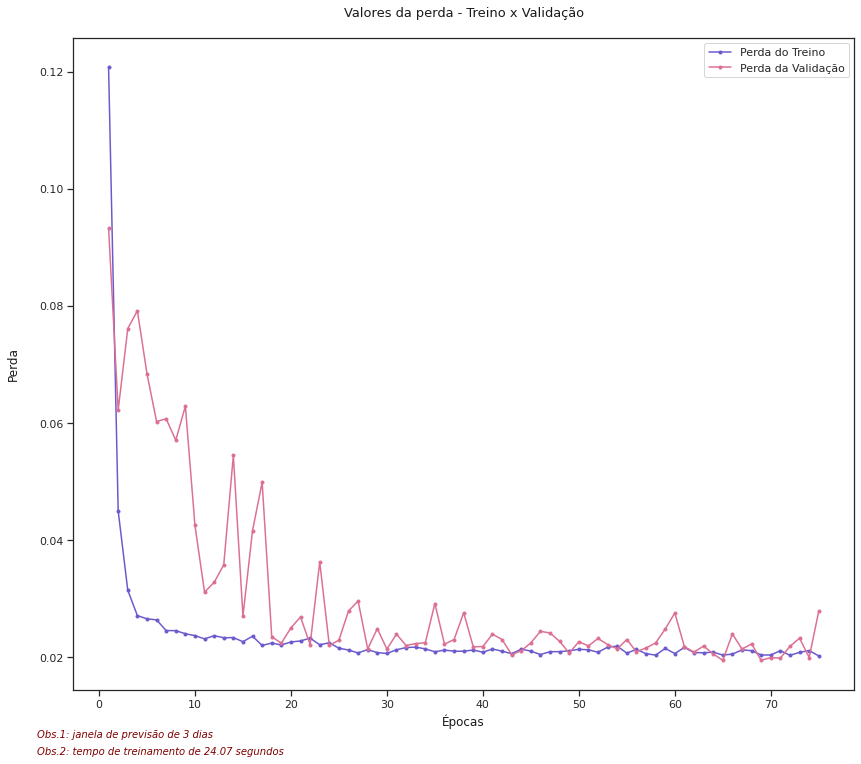



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.2764 
Erro Absoluto Médio (MAE) = 0.2094 
Correlação de Pearson (corr) = 0.9697 
Tempo de treinamento (em segundos): 24.07


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

### Métricas médias do modelo atualizadas para as funções de perdas *mape* e *msle*:
<hr>

In [ ]:
# Função de perda mape:
tf.keras.backend.clear_session() # Clear model
perda = 'mape' # Função de perda
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Função de perda msle:
tf.keras.backend.clear_session() # Clear model
perda = 'msle' # Função de perda
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.40 minutos...
Iteração 3 de 15... em 0.81 minutos...
Iteração 4 de 15... em 1.22 minutos...
Iteração 5 de 15... em 1.63 minutos...
Iteração 6 de 15... em 2.05 minutos...
Iteração 7 de 15... em 2.45 minutos...
Iteração 8 de 15... em 2.86 minutos...
Iteração 9 de 15... em 3.27 minutos...
Iteração 10 de 15... em 3.68 minutos...
Iteração 11 de 15... em 4.09 minutos...
Iteração 12 de 15... em 4.50 minutos...
Iteração 13 de 15... em 5.24 minutos...
Iteração 14 de 15... em 5.65 minutos...
Iteração 15 de 15... em 6.05 minutos...
Fim das iterações...
Tempo total na função: 6.48 minutos 

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.74 minutos...
Iteração 3 de 15... em 1.14 minutos...
Iteração 4 de 15... em 1.54 minutos...
Iteração 5 de 15... em 1.95 minutos...
Iteração 6 de 15... em 2.35 minutos...
Iteração 7 de 15... em 2.76 minutos...
Iteração 8 de 15... em 3.49 minutos...
Iteração 9 de 15... em 3.90 minutos...

,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,relu,0.2,adam,msle,0.232298,0.183843,0.968431,30.440688
1,75,32,3,64,32,relu,0.2,adam,mape,1.307923,1.184158,0.794431,25.347839
2,75,32,3,64,32,relu,0.2,adam,mae,0.285295,0.219959,0.969134,23.537448
3,75,32,3,64,32,relu,0.2,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
4,75,32,3,64,32,relu,0.2,SGD,mse,2.151397,2.083700,0.527686,24.203611
5,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
6,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
7,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
8,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


## ***5.3.3.6. Alterando a função de ativação***
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
perda = 'mse' # Função de perda
ativacao = 'softmax' # Função de ativação das camadas LSTM
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'softmax', 0.2, 'adam', 'mse', 75, 32]


### Treinando para  a função de ativação *softmax*
<hr>

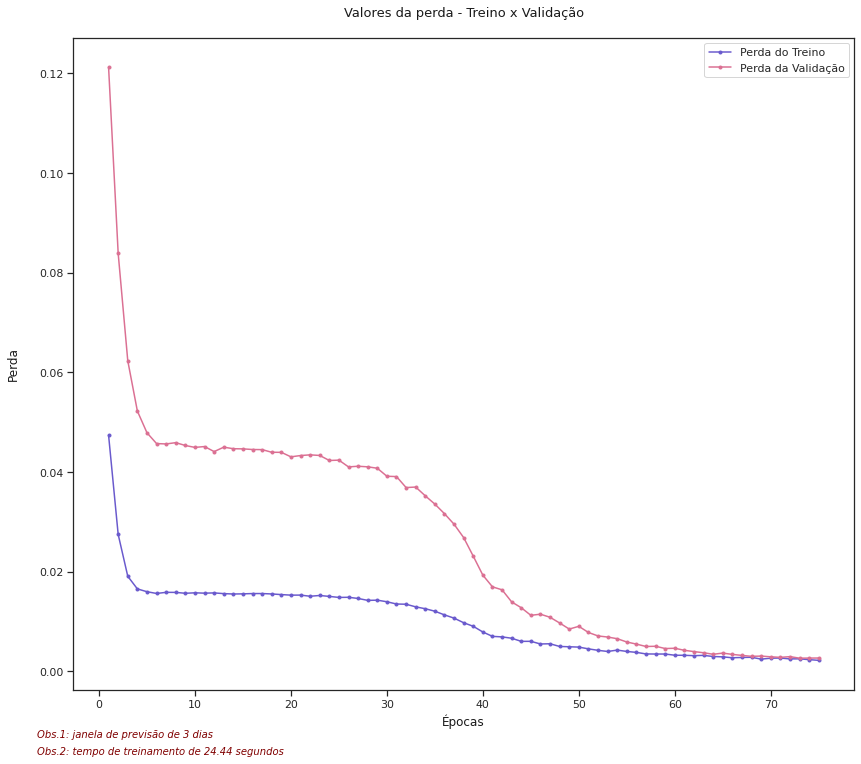

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.43 minutos...
Iteração 3 de 15... em 0.84 minutos...
Iteração 4 de 15... em 1.27 minutos...
Iteração 5 de 15... em 2.01 minutos...
Iteração 6 de 15... em 2.44 minutos...
Iteração 7 de 15... em 2.86 minutos...
Iteração 8 de 15... em 3.29 minutos...
Iteração 9 de 15... em 3.71 minutos...
Iteração 10 de 15... em 4.13 minutos...
Iteração 11 de 15... em 4.54 minutos...
Iteração 12 de 15... em 4.97 minutos...
Iteração 13 de 15... em 5.39 minutos...
Iteração 14 de 15... em 6.12 minutos...
Iteração 15 de 15... em 6.55 minutos...
Fim das iterações...
Tempo total na função: 6.98 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,softmax,0.2,adam,mse,1.627914,1.534429,0.685044,27.305178
1,75,32,3,64,32,relu,0.2,adam,msle,0.232298,0.183843,0.968431,30.440688
2,75,32,3,64,32,relu,0.2,adam,mape,1.307923,1.184158,0.794431,25.347839
3,75,32,3,64,32,relu,0.2,adam,mae,0.285295,0.219959,0.969134,23.537448
4,75,32,3,64,32,relu,0.2,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
5,75,32,3,64,32,relu,0.2,SGD,mse,2.151397,2.083700,0.527686,24.203611
6,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
7,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
8,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577
9,120,16,3,64,32,relu,0.2,RMSprop,mse,0.595126,0.546448,0.970556,67.162557


### Treinando para  a função de ativação *sigmoid*
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
ativacao = 'sigmoid' # Função de ativação das camadas LSTM
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

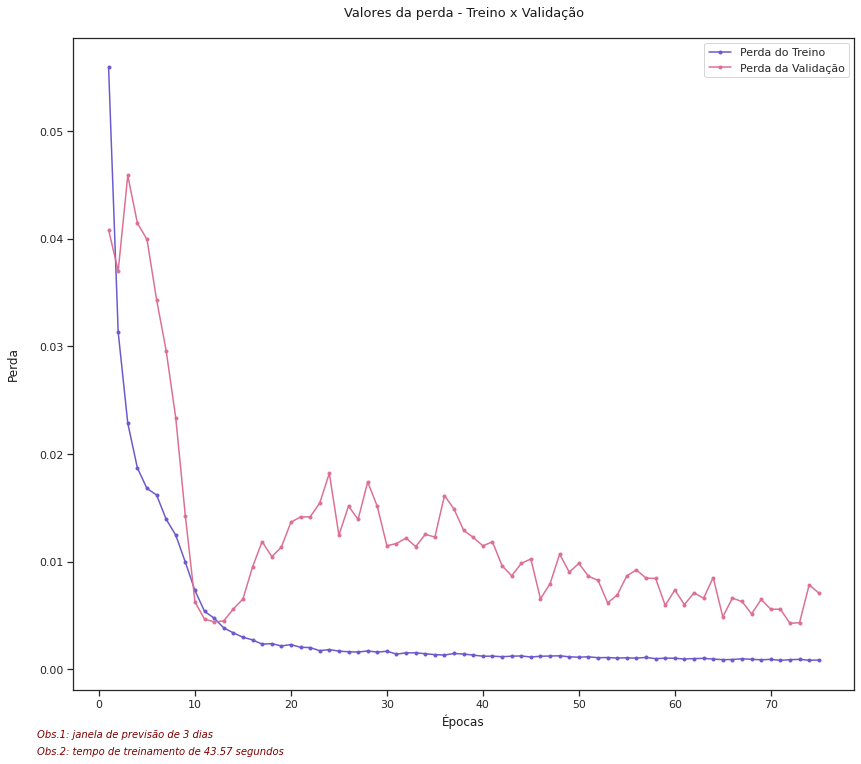

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.40 minutos...
Iteração 3 de 15... em 0.81 minutos...
Iteração 4 de 15... em 1.22 minutos...
Iteração 5 de 15... em 1.62 minutos...
Iteração 6 de 15... em 2.36 minutos...
Iteração 7 de 15... em 2.77 minutos...
Iteração 8 de 15... em 3.51 minutos...
Iteração 9 de 15... em 3.92 minutos...
Iteração 10 de 15... em 4.34 minutos...
Iteração 11 de 15... em 4.74 minutos...
Iteração 12 de 15... em 5.15 minutos...
Iteração 13 de 15... em 5.89 minutos...
Iteração 14 de 15... em 6.31 minutos...
Iteração 15 de 15... em 6.72 minutos...
Fim das iterações...
Tempo total na função: 7.46 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,sigmoid,0.2,adam,mse,0.693628,0.594736,0.967427,29.213276
1,75,32,3,64,32,softmax,0.2,adam,mse,1.627914,1.534429,0.685044,27.305178
2,75,32,3,64,32,relu,0.2,adam,msle,0.232298,0.183843,0.968431,30.440688
3,75,32,3,64,32,relu,0.2,adam,mape,1.307923,1.184158,0.794431,25.347839
4,75,32,3,64,32,relu,0.2,adam,mae,0.285295,0.219959,0.969134,23.537448
5,75,32,3,64,32,relu,0.2,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
6,75,32,3,64,32,relu,0.2,SGD,mse,2.151397,2.083700,0.527686,24.203611
7,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
8,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641
9,75,16,3,64,32,relu,0.2,RMSprop,mse,0.261167,0.229373,0.970862,40.318577


### Treinando para  a função de ativação *tanh*
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
ativacao = 'tanh' # Função de ativação das camadas LSTM
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

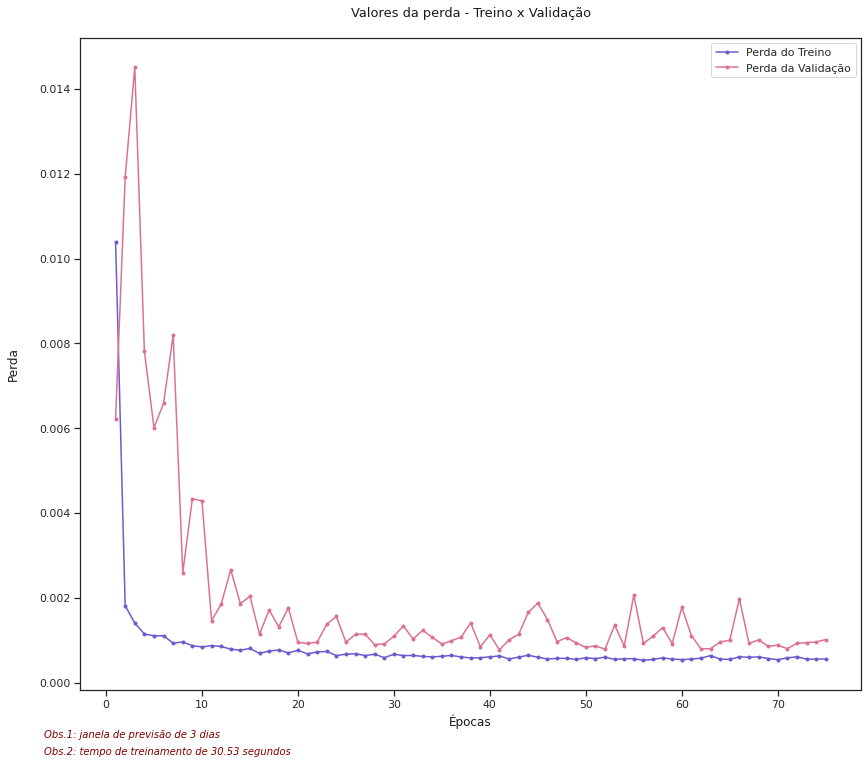

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.77 minutos...
Iteração 3 de 15... em 1.29 minutos...
Iteração 4 de 15... em 1.81 minutos...
Iteração 5 de 15... em 2.32 minutos...
Iteração 6 de 15... em 2.84 minutos...
Iteração 7 de 15... em 3.35 minutos...
Iteração 8 de 15... em 3.89 minutos...
Iteração 9 de 15... em 4.66 minutos...
Iteração 10 de 15... em 5.20 minutos...
Iteração 11 de 15... em 5.73 minutos...
Iteração 12 de 15... em 6.27 minutos...
Iteração 13 de 15... em 6.80 minutos...
Iteração 14 de 15... em 7.58 minutos...
Iteração 15 de 15... em 8.11 minutos...
Fim das iterações...
Tempo total na função: 8.64 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,tanh,0.2,adam,mse,0.143472,0.111354,0.973170,32.830314
1,75,32,3,64,32,sigmoid,0.2,adam,mse,0.693628,0.594736,0.967427,29.213276
2,75,32,3,64,32,softmax,0.2,adam,mse,1.627914,1.534429,0.685044,27.305178
3,75,32,3,64,32,relu,0.2,adam,msle,0.232298,0.183843,0.968431,30.440688
4,75,32,3,64,32,relu,0.2,adam,mape,1.307923,1.184158,0.794431,25.347839
5,75,32,3,64,32,relu,0.2,adam,mae,0.285295,0.219959,0.969134,23.537448
6,75,32,3,64,32,relu,0.2,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
7,75,32,3,64,32,relu,0.2,SGD,mse,2.151397,2.083700,0.527686,24.203611
8,75,32,3,64,32,relu,0.2,adam,mse,0.183153,0.145797,0.969716,29.354176
9,75,32,3,64,32,relu,0.2,RMSprop,mse,0.238101,0.203430,0.969813,29.118641


## ***5.3.3.7. Alterando o dropout***
<hr>

### Treinando para uma taxa de dropout de **15%**
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
ativacao = 'tanh' # Função de ativação das camadas LSTM
dropout_rate = 0.15 # Taxa de dropout
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

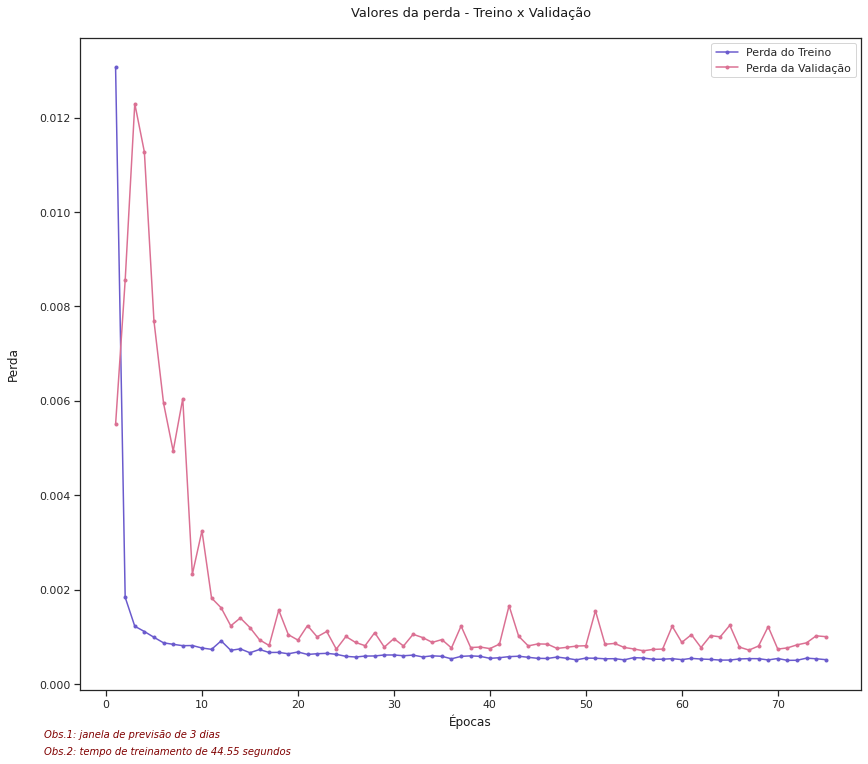

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.53 minutos...
Iteração 3 de 15... em 1.30 minutos...
Iteração 4 de 15... em 2.07 minutos...
Iteração 5 de 15... em 2.85 minutos...
Iteração 6 de 15... em 3.62 minutos...
Iteração 7 de 15... em 4.16 minutos...
Iteração 8 de 15... em 4.69 minutos...
Iteração 9 de 15... em 5.23 minutos...
Iteração 10 de 15... em 5.75 minutos...
Iteração 11 de 15... em 6.30 minutos...
Iteração 12 de 15... em 6.84 minutos...
Iteração 13 de 15... em 7.62 minutos...
Iteração 14 de 15... em 8.39 minutos...
Iteração 15 de 15... em 8.91 minutos...
Fim das iterações...
Tempo total na função: 9.44 minutos 



### Treinando para uma taxa de dropout de **25%**
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
dropout_rate = 0.25 # Taxa de dropout
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

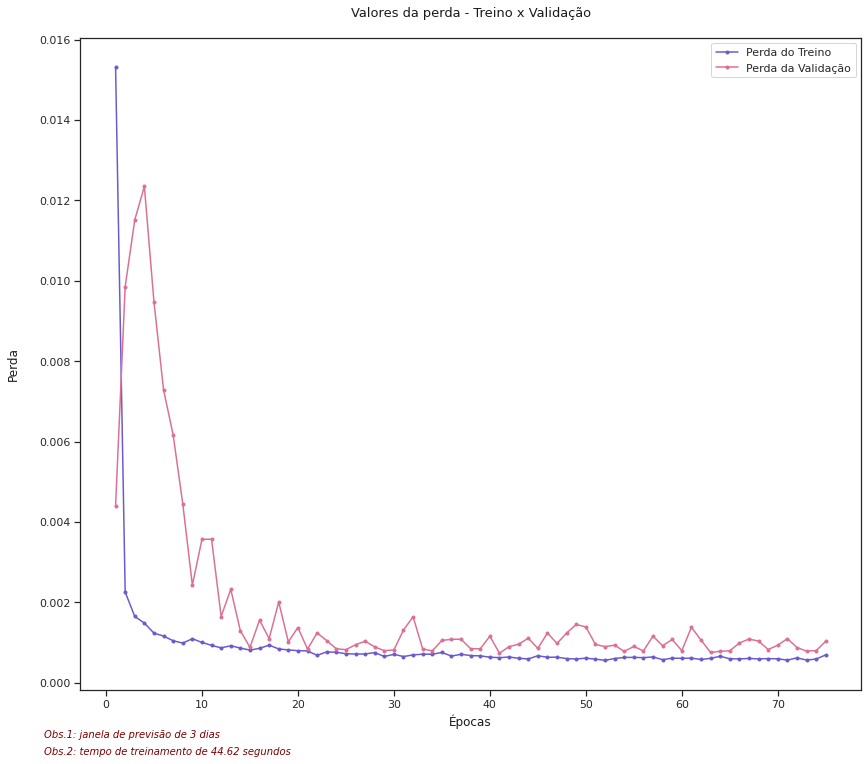

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.54 minutos...
Iteração 3 de 15... em 1.07 minutos...
Iteração 4 de 15... em 1.61 minutos...
Iteração 5 de 15... em 2.14 minutos...
Iteração 6 de 15... em 2.68 minutos...
Iteração 7 de 15... em 3.46 minutos...
Iteração 8 de 15... em 3.99 minutos...
Iteração 9 de 15... em 4.51 minutos...
Iteração 10 de 15... em 5.04 minutos...
Iteração 11 de 15... em 5.56 minutos...
Iteração 12 de 15... em 6.10 minutos...
Iteração 13 de 15... em 6.63 minutos...
Iteração 14 de 15... em 7.39 minutos...
Iteração 15 de 15... em 7.93 minutos...
Fim das iterações...
Tempo total na função: 8.70 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
1,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
2,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
3,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
4,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178
5,75,32,3,64,32,relu,0.20,adam,msle,0.232298,0.183843,0.968431,30.440688
6,75,32,3,64,32,relu,0.20,adam,mape,1.307923,1.184158,0.794431,25.347839
7,75,32,3,64,32,relu,0.20,adam,mae,0.285295,0.219959,0.969134,23.537448
8,75,32,3,64,32,relu,0.20,Adagrad,mse,2.447365,2.387302,0.483464,22.782418
9,75,32,3,64,32,relu,0.20,SGD,mse,2.151397,2.083700,0.527686,24.203611


### Treinando para uma taxa de dropout de **18%**
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
dropout_rate = 0.18 # Taxa de dropout
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

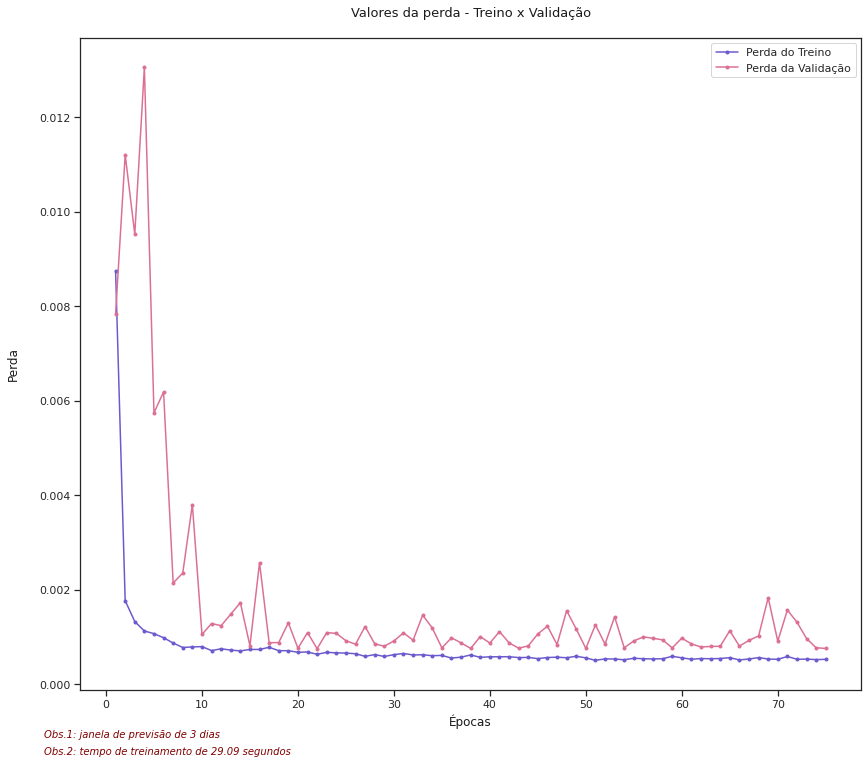

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.77 minutos...
Iteração 3 de 15... em 1.54 minutos...
Iteração 4 de 15... em 2.06 minutos...
Iteração 5 de 15... em 2.84 minutos...
Iteração 6 de 15... em 3.61 minutos...
Iteração 7 de 15... em 4.38 minutos...
Iteração 8 de 15... em 4.92 minutos...
Iteração 9 de 15... em 5.45 minutos...
Iteração 10 de 15... em 5.97 minutos...
Iteração 11 de 15... em 6.49 minutos...
Iteração 12 de 15... em 7.02 minutos...
Iteração 13 de 15... em 7.55 minutos...
Iteração 14 de 15... em 8.10 minutos...
Iteração 15 de 15... em 8.64 minutos...
Fim das iterações...
Tempo total na função: 9.18 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
1,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
2,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
3,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
4,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
5,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178
6,75,32,3,64,32,relu,0.20,adam,msle,0.232298,0.183843,0.968431,30.440688
7,75,32,3,64,32,relu,0.20,adam,mape,1.307923,1.184158,0.794431,25.347839
8,75,32,3,64,32,relu,0.20,adam,mae,0.285295,0.219959,0.969134,23.537448
9,75,32,3,64,32,relu,0.20,Adagrad,mse,2.447365,2.387302,0.483464,22.782418


## ***5.3.3.8. Alterando unidades das camadas LSTM***
<hr>

### Treinando para duas camadas LSTM, uma com 32 unidades e outra com 16
<hr>

In [ ]:
# Redefinindo o número das unidades das camadas LSTM 
# e ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
dropout_rate = 0.18 # Taxa de dropout
LSTM_units_1 = 32 # Número de unidades da primeira camada
LSTM_units_2 = 16 # Número de unidades da segunda camada
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 32, 16, 'tanh', 0.18, 'adam', 'mse', 75, 32]


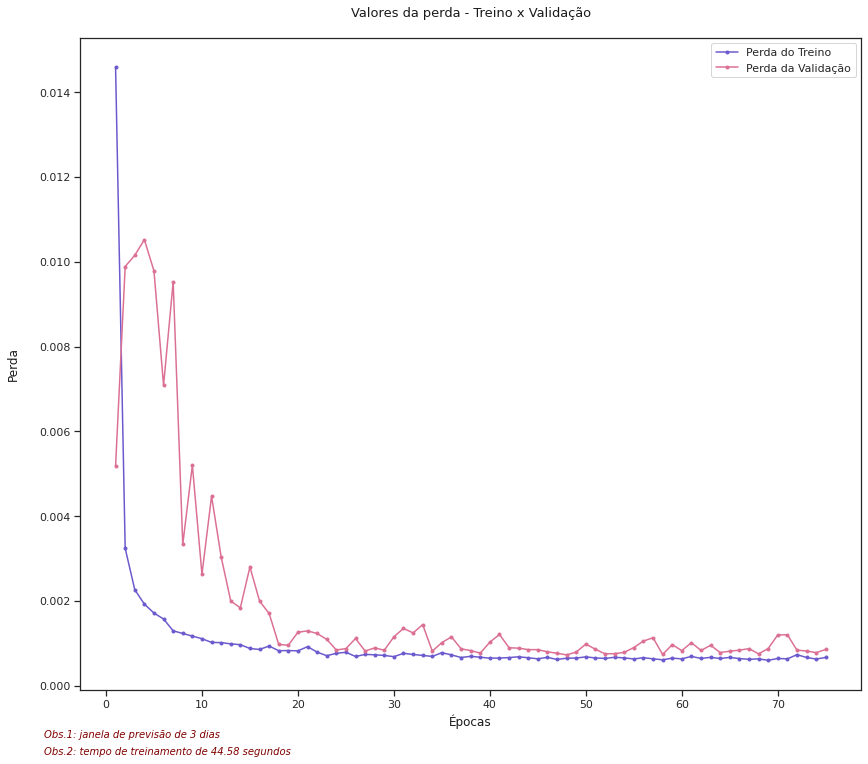

In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.78 minutos...
Iteração 3 de 15... em 1.29 minutos...
Iteração 4 de 15... em 1.80 minutos...
Iteração 5 de 15... em 2.31 minutos...
Iteração 6 de 15... em 2.84 minutos...
Iteração 7 de 15... em 3.37 minutos...
Iteração 8 de 15... em 4.14 minutos...
Iteração 9 de 15... em 4.65 minutos...
Iteração 10 de 15... em 5.17 minutos...
Iteração 11 de 15... em 5.68 minutos...
Iteração 12 de 15... em 6.21 minutos...
Iteração 13 de 15... em 6.74 minutos...
Iteração 14 de 15... em 7.26 minutos...
Iteração 15 de 15... em 7.79 minutos...
Fim das iterações...
Tempo total na função: 8.56 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
1,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
2,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
3,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
4,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
5,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
6,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178
7,75,32,3,64,32,relu,0.20,adam,msle,0.232298,0.183843,0.968431,30.440688
8,75,32,3,64,32,relu,0.20,adam,mape,1.307923,1.184158,0.794431,25.347839
9,75,32,3,64,32,relu,0.20,adam,mae,0.285295,0.219959,0.969134,23.537448


### Treinando para uma camada LSTM com 64 unidades
<hr>

In [ ]:
# Redefinindo o número das unidades das camadas LSTM 
# e ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
LSTM_units_1 = 64 # Número de unidades da primeira camada
LSTM_units_2 = 0 # Número de unidades da segunda camada
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 0, 'tanh', 0.18, 'adam', 'mse', 75, 32]


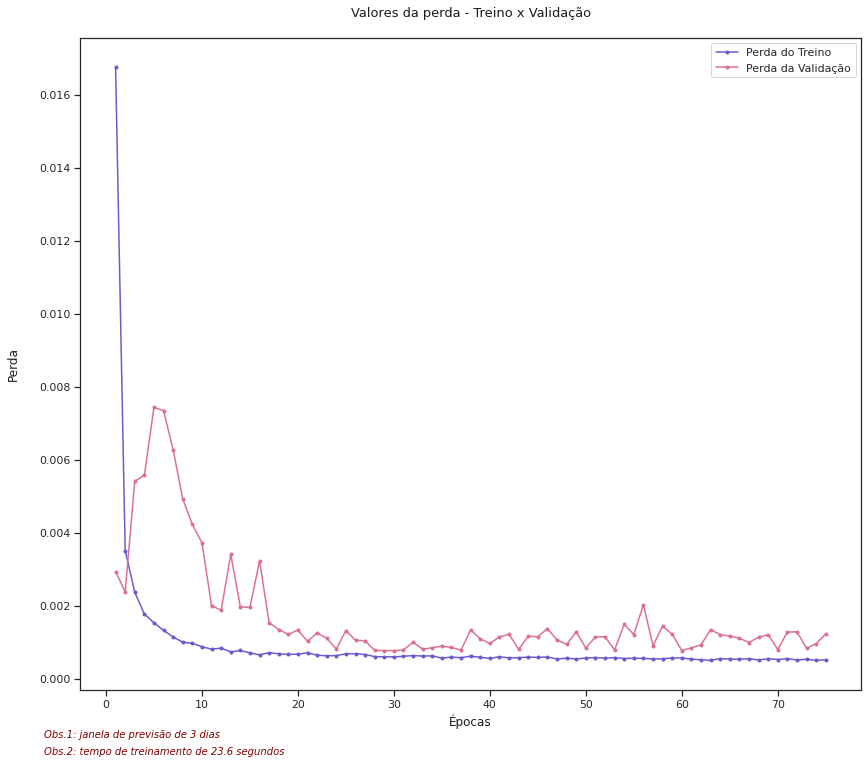



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1798 
Erro Absoluto Médio (MAE) = 0.1479 
Correlação de Pearson (corr) = 0.9736 
Tempo de treinamento (em segundos): 23.6


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.35 minutos...
Iteração 3 de 15... em 0.69 minutos...
Iteração 4 de 15... em 1.04 minutos...
Iteração 5 de 15... em 1.43 minutos...
Iteração 6 de 15... em 1.77 minutos...
Iteração 7 de 15... em 2.17 minutos...
Iteração 8 de 15... em 2.50 minutos...
Iteração 9 de 15... em 2.89 minutos...
Iteração 10 de 15... em 3.23 minutos...
Iteração 11 de 15... em 3.63 minutos...
Iteração 12 de 15... em 3.97 minutos...
Iteração 13 de 15... em 4.30 minutos...
Iteração 14 de 15... em 4.63 minutos...
Iteração 15 de 15... em 5.03 minutos...
Fim das iterações...
Tempo total na função: 5.37 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
1,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
2,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
3,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
4,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
5,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
6,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
7,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178
8,75,32,3,64,32,relu,0.20,adam,msle,0.232298,0.183843,0.968431,30.440688
9,75,32,3,64,32,relu,0.20,adam,mape,1.307923,1.184158,0.794431,25.347839


### Treinando para uma camada LSTM com 32 unidades
<hr>

In [ ]:
# Redefinindo o número das unidades das camadas LSTM 
# e ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
LSTM_units_1 = 32 # Número de unidades da primeira camada
LSTM_units_2 = 0 # Número de unidades da segunda camada
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 32, 0, 'tanh', 0.18, 'adam', 'mse', 75, 32]


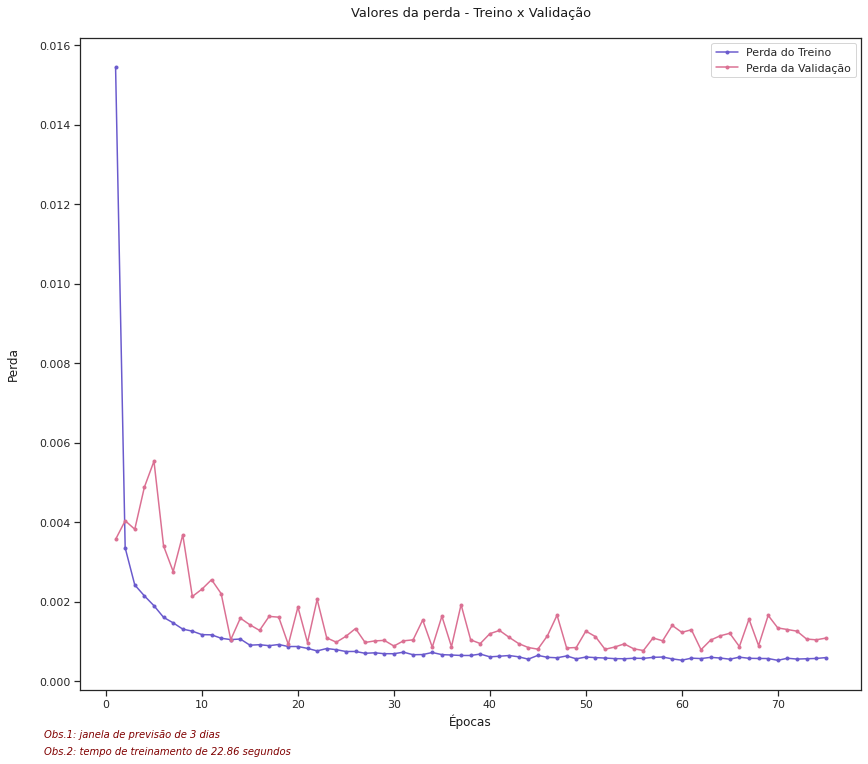



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1476 
Erro Absoluto Médio (MAE) = 0.1137 
Correlação de Pearson (corr) = 0.9731 
Tempo de treinamento (em segundos): 22.86


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}")

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 0.40 minutos...
Iteração 3 de 15... em 0.71 minutos...
Iteração 4 de 15... em 1.11 minutos...
Iteração 5 de 15... em 1.50 minutos...
Iteração 6 de 15... em 1.89 minutos...
Iteração 7 de 15... em 2.20 minutos...
Iteração 8 de 15... em 2.50 minutos...
Iteração 9 de 15... em 2.81 minutos...
Iteração 10 de 15... em 3.12 minutos...
Iteração 11 de 15... em 3.44 minutos...
Iteração 12 de 15... em 3.84 minutos...
Iteração 13 de 15... em 4.15 minutos...
Iteração 14 de 15... em 4.46 minutos...
Iteração 15 de 15... em 4.77 minutos...
Fim das iterações...
Tempo total na função: 5.10 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,3,32,0,tanh,0.18,adam,mse,0.148039,0.115877,0.972901,19.764344
1,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
2,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
3,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
4,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
5,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
6,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
7,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
8,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178
9,75,32,3,64,32,relu,0.20,adam,msle,0.232298,0.183843,0.968431,30.440688


## ***5.3.3.9. Alterando a janela de previsão***
<hr>

### Uma alteração interessante a ser pesquisada é saber como a janela para a qual se olha no passado interfere no desempenho do modelo. Além da janela atual, de 3 dias no passado, duas outras janelas serão experimentadas: 7 dias no passado para 1 no futuro (uma semana); e 15 dias no passado para 1 no futuro (uma quinzena)
<hr>

### Janela de **7 dias:**
<hr>

In [ ]:
# Janela de previsão:
future = 1 # Previsão de 1 dia no futuro
past = 7 # Com base nos dados dos 7 últimos dias

# Retornando os tensores de: dados completos (X, Y); treinamento (X_train, y_train);
# validação (X_validation, y_validation); e teste (X_test, y_test):
(X, y,
 X_train, y_train,
 X_validation, y_validation,
 X_test, y_test,
 len_validation, len_test) = cria_tensores (nd_lstm_scaled, future, past)

Forma dos dados completos (tensores X, y):
 (2169, 7, 6) (2169, 1)
Forma dos dados de treino (tensores X_train, y_train):
 (1627, 7, 6) (1627, 1)
Forma dos dados de validação (tensores X_validation, y_validation):
 (325, 7, 6) (325, 1)
Forma dos dados de teste (tensores X_test, y_test):
 (217, 7, 6) (217, 1)


In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
janela = past # Janela de dias para o passado
LSTM_units_1 = 64 # Número de unidades da primeira camada
LSTM_units_2 = 32 # Número de unidades da segunda camada
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 7, 64, 32, 'tanh', 0.18, 'adam', 'mse', 75, 32]


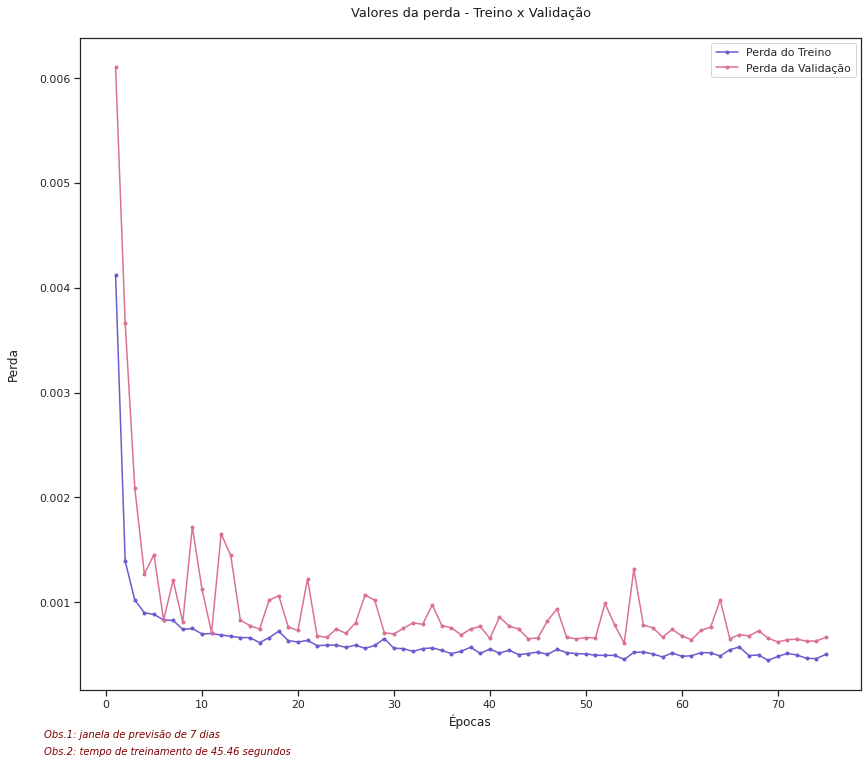



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.2943 
Erro Absoluto Médio (MAE) = 0.2535 
Correlação de Pearson (corr) = 0.9728 
Tempo de treinamento (em segundos): 45.46


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)
# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 1.47 minutos...
Iteração 3 de 15... em 2.22 minutos...
Iteração 4 de 15... em 3.01 minutos...
Iteração 5 de 15... em 3.77 minutos...
Iteração 6 de 15... em 5.23 minutos...
Iteração 7 de 15... em 6.69 minutos...
Iteração 8 de 15... em 7.47 minutos...
Iteração 9 de 15... em 8.23 minutos...
Iteração 10 de 15... em 8.98 minutos...
Iteração 11 de 15... em 9.77 minutos...
Iteração 12 de 15... em 11.23 minutos...
Iteração 13 de 15... em 12.04 minutos...
Iteração 14 de 15... em 12.82 minutos...
Iteração 15 de 15... em 13.62 minutos...
Fim das iterações...
Tempo total na função: 14.41 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,7,64,32,tanh,0.18,adam,mse,0.245084,0.201633,0.972295,55.985960
1,75,32,3,32,0,tanh,0.18,adam,mse,0.148039,0.115877,0.972901,19.764344
2,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
3,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
4,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
5,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
6,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
7,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
8,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276
9,75,32,3,64,32,softmax,0.20,adam,mse,1.627914,1.534429,0.685044,27.305178


### Janela de **15 dias:**
<hr>

In [ ]:
# Janela de previsão:
future = 1 # Previsão de 1 dia no futuro
past = 15 # Com base nos dados dos 15 últimos dias

# Retornando os tensores de: dados completos (X, Y); treinamento (X_train, y_train);
# validação (X_validation, y_validation); e teste (X_test, y_test):
(X, y,
 X_train, y_train,
 X_validation, y_validation,
 X_test, y_test,
 len_validation, len_test) = cria_tensores (nd_lstm_scaled, future, past)

Forma dos dados completos (tensores X, y):
 (2161, 15, 6) (2161, 1)
Forma dos dados de treino (tensores X_train, y_train):
 (1621, 15, 6) (1621, 1)
Forma dos dados de validação (tensores X_validation, y_validation):
 (324, 15, 6) (324, 1)
Forma dos dados de teste (tensores X_test, y_test):
 (216, 15, 6) (216, 1)


In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
janela = past # Janela de dias para o passado
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 15, 64, 32, 'tanh', 0.18, 'adam', 'mse', 75, 32]


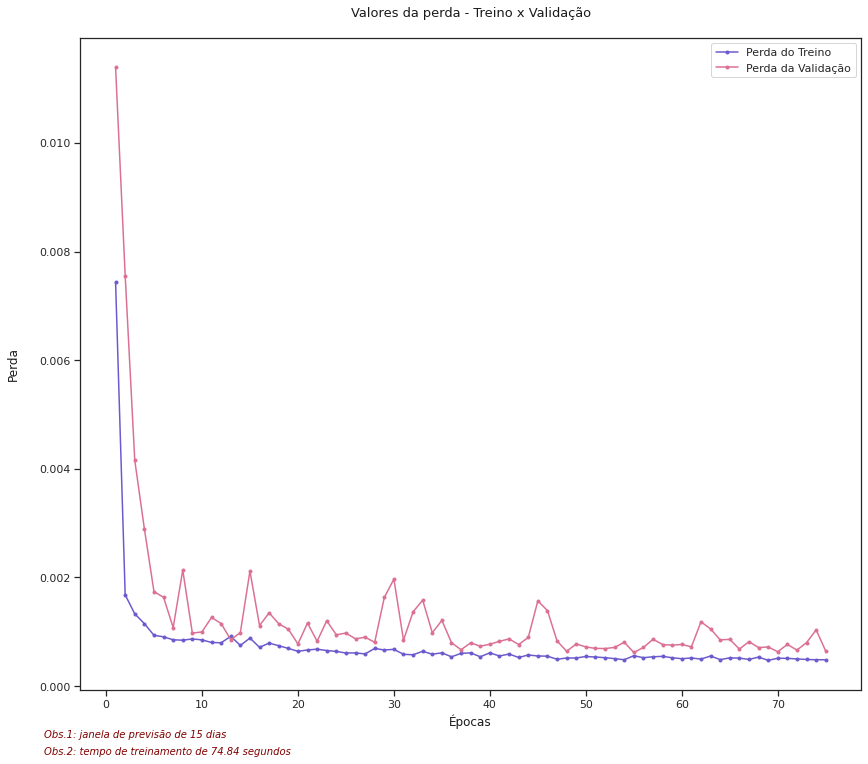



Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.3433 
Erro Absoluto Médio (MAE) = 0.3013 
Correlação de Pearson (corr) = 0.9704 
Tempo de treinamento (em segundos): 74.84


In [ ]:
# Plotando as perdas de validação e teste,
# e salvando o modelo para a previsão
(history, time_lstm) = plot_loss_and_save_model (hiper_par_list, path_keras_predict, path_fig)

# Imprimindo as métricas para o modelo salvo
# Retorna ndarray com y_pred:
y_pred = func_prediction (hiper_par_list, path_keras_predict)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino) = calc_mean_metrics (hiper_par_list,
                                         X_train, y_train,
                                         X_validation, y_validation,
                                         X_test, y_test)

# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

Iteração 1 de 15... em 0.00 minutos...
Iteração 2 de 15... em 1.25 minutos...
Iteração 3 de 15... em 2.52 minutos...
Iteração 4 de 15... em 3.76 minutos...
Iteração 5 de 15... em 5.01 minutos...
Iteração 6 de 15... em 6.47 minutos...
Iteração 7 de 15... em 7.92 minutos...
Iteração 8 de 15... em 9.20 minutos...
Iteração 9 de 15... em 10.45 minutos...
Iteração 10 de 15... em 11.71 minutos...
Iteração 11 de 15... em 12.94 minutos...
Iteração 12 de 15... em 14.41 minutos...
Iteração 13 de 15... em 15.65 minutos...
Iteração 14 de 15... em 16.91 minutos...
Iteração 15 de 15... em 18.15 minutos...
Fim das iterações...
Tempo total na função: 19.38 minutos 



,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,75,32,15,64,32,tanh,0.18,adam,mse,0.263660,0.221104,0.971693,75.827589
1,75,32,7,64,32,tanh,0.18,adam,mse,0.245084,0.201633,0.972295,55.985960
2,75,32,3,32,0,tanh,0.18,adam,mse,0.148039,0.115877,0.972901,19.764344
3,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
4,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
5,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
6,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
7,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309
8,75,32,3,64,32,tanh,0.20,adam,mse,0.143472,0.111354,0.973170,32.830314
9,75,32,3,64,32,sigmoid,0.20,adam,mse,0.693628,0.594736,0.967427,29.213276


### Como esperado, a janela de previsão com menos dias no passado encontra melhores resultados para a previsão de séries temporais. Em outras palavras, quanto mais se avança para o futuro mais incerta será a previsão
### Assim, mantém-se a **janela de 3 dias no passado para prever 1 dia no futuro**
<hr>

In [ ]:
# Retornando os dados para a janela original:
# Janela de previsão:
future = 1 # Previsão de 1 dia no futuro
past = 3 # Com base nos dados dos 3 últimos dias

# Retornando os tensores de: dados completos (X, Y); treinamento (X_train, y_train);
# validação (X_validation, y_validation); e teste (X_test, y_test):
(X, y,
 X_train, y_train,
 X_validation, y_validation,
 X_test, y_test,
 len_validation, len_test) = cria_tensores (nd_lstm_scaled, future, past)

Forma dos dados completos (tensores X, y):
 (2173, 3, 3) (2173, 1)
Forma dos dados de treino (tensores X_train, y_train):
 (1630, 3, 3) (1630, 1)
Forma dos dados de validação (tensores X_validation, y_validation):
 (326, 3, 3) (326, 1)
Forma dos dados de teste (tensores X_test, y_test):
 (217, 3, 3) (217, 1)


In [ ]:
# Ajustando a lista de hiper parâmetros:
janela = past # Janela de dias para o passado
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'tanh', 0.18, 'adam', 'mse', 75, 32]


## ***5.3.3.10. Regularização do modelo usando Keras Callbacks API***
<hr>


### Fazendo a regularização via Callbacks:
### Definindo o nome do modelo a ser salvo:
<hr>

In [ ]:
# Nomes arquivos LSTM:
# arq_keras_LSTM_1 = LSTM_keras_path+'LSTM_1_keras_model.hdf5' 
arq_keras_LSTM_1 = LSTM_keras_path+'LSTM_1_{epoch:03d}_keras_model.hdf5' 
arq_LSTM_1_logs = LSTM_logs_path+'LSTM_1_logs.csv'

# Lista de ***callbacks***:
<hr>

In [ ]:
# Ajustando a lista de hiper parâmetros:
tf.keras.backend.clear_session() # Clear model
epocas= 250 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]
[15, 3, 64, 32, 'tanh', 0.18, 'adam', 'mse', 250, 32]


In [ ]:
# Listas individuais de CallBakcs:
cb_early_stopping = EarlyStopping(monitor='val_loss', 
                                  mode='min',
                                  patience=75, 
                                  restore_best_weights = True,
                                  verbose=1)

cb_model_checkpoint = ModelCheckpoint(arq_keras_LSTM_1,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      verbose=1)

cv_csv_logger = CSVLogger(arq_LSTM_1_logs,
                          separator=',',
                          append=False)

# Lista de Callbacks final:
callback_list = [
    cb_early_stopping,
    cb_model_checkpoint,
    cv_csv_logger
    ]

### Definindo arquitetura, compilador, hiper parâmetros e treinando:
<hr>

In [ ]:
# Arquitetura da rede:
model = Sequential()
if hiper_par_list[3] > 0:
  model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                 input_shape=(X_train.shape[1], X_train.shape[2]),
                 return_sequences=True))
  model.add(LSTM(hiper_par_list[3], activation=hiper_par_list[4],
                 return_sequences=False))
else:
  model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                 return_sequences=False))
model.add(Dropout(hiper_par_list[5]))
model.add(Dense(y_train.shape[1]))

# Informando novas métricas ao compilador:
model.compile(optimizer=hiper_par_list[6],
              loss=hiper_par_list[7],  metrics=['mae','msle'])
# Treinamento:
start_time = time.time() #Start do tempo para avaliar a demanda computacional
history = model.fit(X_train, y_train,
                    epochs=hiper_par_list[8],
                    batch_size=hiper_par_list[9],
                    validation_data=(X_validation,y_validation),
                    callbacks = callback_list,
                    verbose=1)
final_time = time.time() #Tempo final para avaliar a demanda computacional
time_lstm = final_time - start_time # Tempo gasto no treinamento do modelo

Epoch 1/250
51/51 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0759 - msle: 0.0071
Epoch 1: val_loss improved from inf to 0.00391, saving model to /content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_LSTM_MODELS/LSTM_1_001_keras_model.hdf5
51/51 [==============================] - 6s 28ms/step - loss: 0.0104 - mae: 0.0759 - msle: 0.0071 - val_loss: 0.0039 - val_mae: 0.0520 - val_msle: 0.0020
Epoch 2/250
49/51 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0328 - msle: 0.0012
Epoch 2: val_loss did not improve from 0.00391
51/51 [==============================] - 0s 8ms/step - loss: 0.0019 - mae: 0.0327 - msle: 0.0012 - val_loss: 0.0113 - val_mae: 0.0878 - val_msle: 0.0056
Epoch 3/250
45/51 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0274 - msle: 8.8061e-04
Epoch 3: val_loss did not improve from 0.00391
51/51 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0274 - msle: 8.7536e-04 - val_loss: 0.0103 - val_

In [ ]:
# Resumo do modelo:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


### ***Gráficos e resultados LSTM_1:***
<hr>

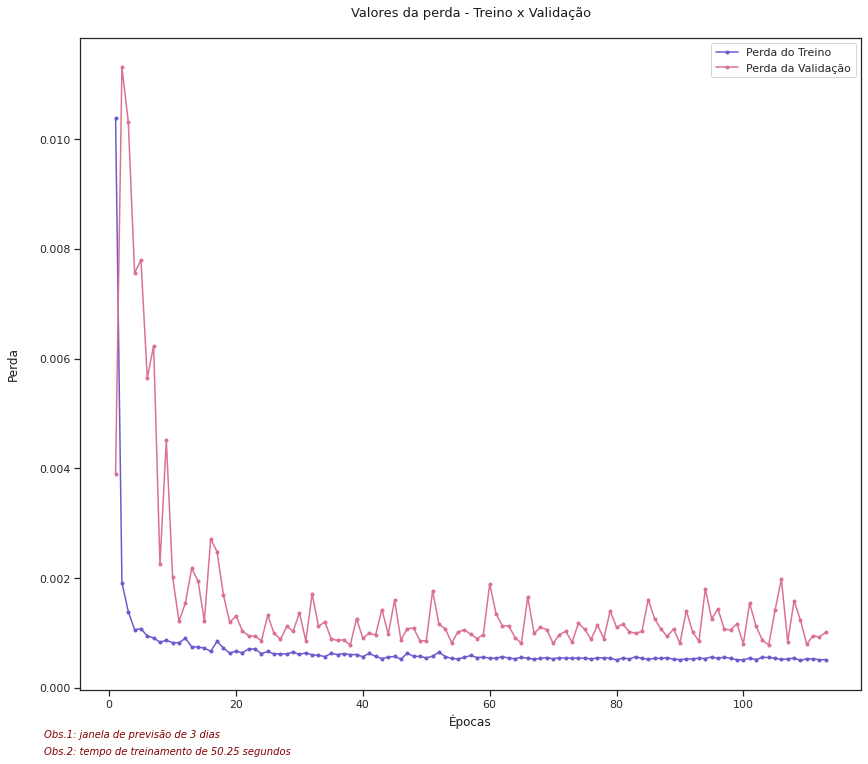

In [ ]:
# Plotando os gráficos das perdas:
plot_train_val_loss (history, time_lstm, path_fig)

### Funções criadas para manipular os arquivos dos modelos Keras:
<hr>

In [ ]:
# Função cria a lista de arquivos:
def listaArquivos (pasta, ext='.hdf5'):
    lista_caminhos = []
    lista_arqs = []
    lista_caminhos_arqs = []
    caminhoAbsoluto = os.path.abspath(pasta)
    for pastaAtual, subPastas, arquivos  in os.walk(caminhoAbsoluto):
        lista_caminhos.extend([os.path.join(pastaAtual) for arquivo in arquivos if arquivo.endswith(ext)])
        lista_arqs.extend([os.path.join(arquivo) for arquivo in arquivos if arquivo.endswith(ext)])
        lista_caminhos_arqs.extend([os.path.join(pastaAtual,arquivo) for arquivo in arquivos if arquivo.endswith(ext)])
    return [lista_caminhos, lista_arqs, lista_caminhos_arqs]

# Criando a lista com o nome dos arquivos LSTM
arquivos_hdf5 = listaArquivos (LSTM_keras_path, ext='.hdf5')

In [ ]:
# Criando o dataframe com o nome dos arquivos LSTM
df_arqs_LSTM = pd.DataFrame(arquivos_hdf5).transpose()
df_arqs_LSTM.columns = ['caminhos', 'nomes_arqs', 'caminhos_nomes_arqs']

In [ ]:
# Função para ordenar os arquivos LSTM:
def ordenando_df_lstm (df_ord):
  ordem_lstm = []
  for item_df in df_ord['nomes_arqs']: 
    ordem_lstm.append(str(item_df[7:10]))    
  df_ord['ordem_lstm_temp']=ordem_lstm
  del ordem_lstm
  df_ord.sort_values(['ordem_lstm_temp'], inplace=True, ascending=False)
  df_ord.drop(['ordem_lstm_temp'], axis=1, inplace=True)
  df_ord.reset_index(drop=True, inplace=True)
  return df_ord

# Ordenando o dataframe com o nome dos arquivos em ordem decrescente:
df_ordenado = ordenando_df_lstm(df_arqs_LSTM)

In [ ]:
# Recuperando o "melhor modelo" Keras:
model_LSTM_1 = load_model(df_ordenado['caminhos_nomes_arqs'][0])
print(f"\nNome arquivo do modelo Keras recuperado: {df_ordenado['nomes_arqs'][0]}")

# Previsão para o "melhor modelo":
forecast = model_LSTM_1.predict(X_test, verbose=0)
forecast_copies = np.repeat(forecast, df_lstm.shape[1], axis=-1)
y_pred = scaler.inverse_transform(forecast_copies)[:, 0]

# Verificando as métricas:
lstm_result = validation(df_new.iloc[-len_test:,0].values, y_pred)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 


Nome arquivo do modelo Keras recuperado: LSTM_1_038_keras_model.hdf5


Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1608 
Erro Absoluto Médio (MAE) = 0.1262 
Correlação de Pearson (corr) = 0.9727 
Tempo de treinamento (em segundos): 50.25


In [ ]:
# Métricas do melhor modelo:
RMSE_LSTM_1 = lstm_result['RMSE']
MAE_LSTM_1 = lstm_result['MAE']
corr_LSTM_1 = lstm_result['corr']
tempo_treino_LSTM_1 = time_lstm

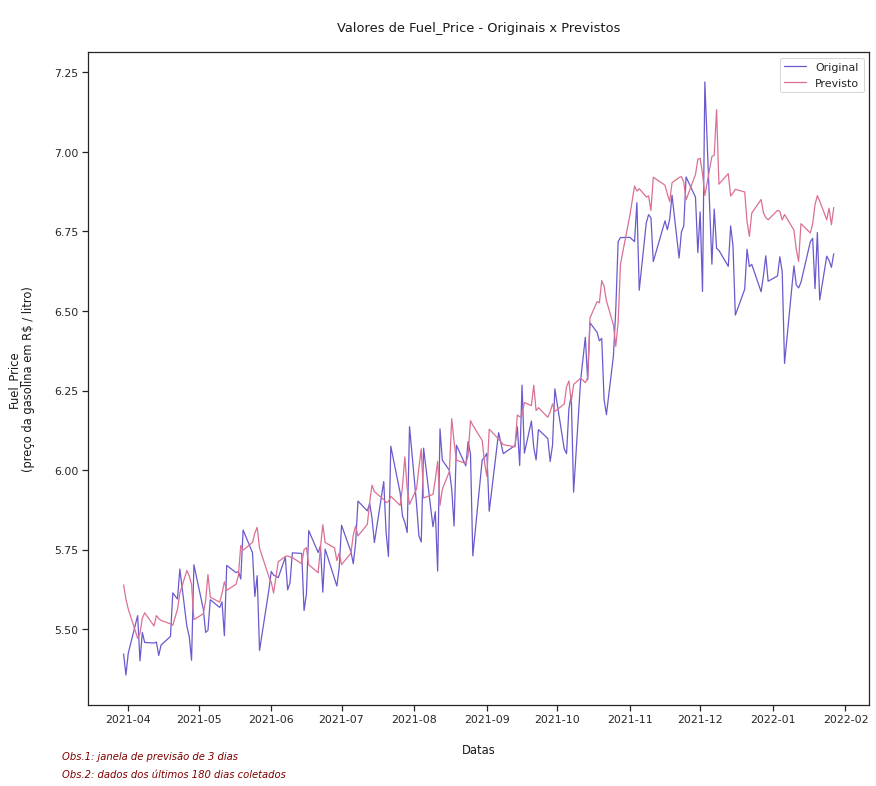

In [ ]:
# Plotando o gráfico da previsão:
plot_predict (past, df_lstm_dates, df_new, len_test,y_pred, path_fig)

### Salvando os resultados em ***df_all_metrics*** e ***df_ypred***:
<hr>

In [ ]:
# Lendo df_all_metrics:
df_all_metrics = pd.read_csv(path_backup_df+'df_all_metrics.csv')
# Lendo df_ypred:
df_ypred = pd.read_csv(path_backup_df+'df_ypred.csv')

In [ ]:
# Atualizando dataframe de métricas:
index_all_metrics = df_all_metrics.shape[0] # Index de df_all_metrics a ser atualizado
df_all_metrics.loc[index_all_metrics] = [f'LSTM_1',
                                         RMSE_LSTM_1,
                                         MAE_LSTM_1,
                                         corr_LSTM_1,
                                         round(tempo_treino_LSTM_1,2)] 
index_all_metrics += 1
df_all_metrics

,MODELO,RMSE,MAE,corr,Tempo_Processamento
0,ARIMA_1,0.122246,0.091244,0.990621,804.27
1,ARIMA_2,0.122158,0.091162,0.990630,996.20
2,VAR_1,0.123234,0.090607,0.990291,8.50
3,VAR_2,0.122975,0.090667,0.990388,4.26
4,LSTM_1,0.160811,0.126215,0.972672,50.25


In [ ]:
# Atualizando o dataframe de predições:
df_ypred.loc[:,'y_LSTM_1'] = y_pred
df_ypred.head()

,DATAS,y_REAL,y_ARIMA_1,y_ARIMA_2,y_VAR_1,y_VAR_2,y_LSTM_1,y_LSTM_2
0,2021-01-26,4.786904,4.617979,4.624590,4.640301,4.628515,4.670801,NaN
1,2021-01-27,4.627419,4.633419,4.632962,4.655449,4.657515,4.701144,NaN
2,2021-01-28,4.533405,4.639840,4.632933,4.670426,4.651163,4.745069,NaN
3,2021-02-01,4.849375,4.644449,4.645650,4.640620,4.651114,4.742723,NaN
4,2021-02-02,4.778471,4.673378,4.678649,4.675744,4.691742,4.701520,NaN


In [ ]:
# Alterando os arquivos LSTM de pasta:
for kk, ww  in zip(df_ordenado['nomes_arqs'],
                   df_ordenado['caminhos_nomes_arqs']):
  old_name = ww # Nome/pasta antiga
  new_name = keras_moved_files_path + kk # Nome/pasta nova
  time.sleep(1)
  # Alterando o diretório/nomes dos arquivos dos modelos:
  os.replace(old_name, new_name)

### Para fins de comparação, atualizando df_metricas com valores médios encotrados por meio da **regularização** via Keras ***callbacks***:
<hr>

In [ ]:
# Criando a função para loop de aprendizado e escolha de melhor modelo
def calc_keras_mean (hiper_par_list,
                     X_train, y_train,
                     X_validation, y_validation,
                     X_test, y_test,
                     keras_mean_path,
                     keras_moved_files_path):
  
  t1 = time.time() # Tempo de processamento inicial da função
  epocas = [] # Lista de épocas para calcular as épocas médias
  RMSE_list = [] # Criando lista RMSE
  MAE_list = [] # Criando lista MAE
  corr_list = [] # Criando lista CORR
  tempo_medio_list = [] # Criando a lista com o tempo médio de treinamento

  # Criando o loop para cálculo das médias:
  for i in range(hiper_par_list[0]):

    print(f"Iteração {i+1} de {hiper_par_list[0]}... em {(time.time()-t1)/60:.2f} minutos...")

    # Arquitetura da rede:
    tf.keras.backend.clear_session() # Clear model  
    # Nome do arquivo
    arq_keras_MEAN_X = keras_mean_path+'MEAN_X_{epoch:03d}_keras_model.hdf5'

    # Listas individuais de CallBakcs para cálculo das médias:
    cb_early_stopping_new = EarlyStopping(monitor='val_loss', 
                                          mode='min', patience=75, 
                                          restore_best_weights = True,
                                          verbose=0)
    cb_model_checkpoint_new = ModelCheckpoint(arq_keras_MEAN_X,
                                              monitor='val_loss',mode='min',
                                              save_best_only=True, verbose=0)
    # Lista de Callbacks final para cálculo das médias:
    new_callback_list = [cb_early_stopping_new, cb_model_checkpoint_new]     
    
    # Arquitetura da rede:
    model = Sequential()
    if hiper_par_list[3] > 0:
      model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     return_sequences=True))
      model.add(LSTM(hiper_par_list[3], activation=hiper_par_list[4],
                     return_sequences=False))
    else:
      model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                     return_sequences=False))
    model.add(Dropout(hiper_par_list[5]))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer=hiper_par_list[6],
                  loss=hiper_par_list[7])
     
    # Treinamento:
    start_time = time.time() #Start do tempo para avaliar a demanda computacional
    history = model.fit(X_train, y_train,
                        epochs=hiper_par_list[8],
                        batch_size=hiper_par_list[9],
                        validation_data=(X_validation,y_validation),
                        callbacks = new_callback_list,
                        verbose=0)
    final_time = time.time() #Tempo final para avaliar a demanda computacional
    time_lstm = final_time - start_time # Tempo gasto no treinamento do modelo
    epocas.append(len(history.history['loss']))

    # Criando a lista com o nome dos arquivos LSTM MEAN:
    arquivos_MEAN_X_hdf5 = listaArquivos (keras_mean_path, ext='.hdf5')
    # Criando o dataframe com o nome dos arquivos LSTM MEAN:
    df_arqs_MEAN_X = pd.DataFrame(arquivos_MEAN_X_hdf5).transpose()
    df_arqs_MEAN_X.columns = ['caminhos', 'nomes_arqs', 'caminhos_nomes_arqs']
    # Ordenando o dataframe com o nome dos arquivos em ordem decrescente:
    df_ordenado_MEAN_X = ordenando_df_lstm(df_arqs_MEAN_X)
      
    # Recuperando o modelo keras:
    mean_model = load_model(df_ordenado_MEAN_X['caminhos_nomes_arqs'][0])
    print(f"\nNome arquivo do modelo Keras recuperado: {df_ordenado_MEAN_X['nomes_arqs'][0]}")
    
    # Previsão:
    forecast = mean_model.predict(X_test, verbose=0)
    forecast_copies = np.repeat(forecast, df_lstm.shape[1], axis=-1)
    y_pred_MEAN = scaler.inverse_transform(forecast_copies)[:, 0]
    
    # Verificando as métricas:
    lstm_result = validation_LSTM(df_new.iloc[-len_test:,0].values, y_pred_MEAN)

    # Atualizando listas de métricas:
    RMSE_list.append(lstm_result['RMSE']) 
    MAE_list.append(lstm_result['MAE'])
    corr_list.append(lstm_result['corr'])
    tempo_medio_list.append(final_time - start_time)
    
    # Removendo os arquivos LSTM de pasta:
    for nome_arquivo in df_ordenado_MEAN_X['caminhos_nomes_arqs']:
      os.remove(nome_arquivo)
      time.sleep(1)
    
  # RESULTADOS para atualizar o DataFrame de métricas:
  mean_RMSE = np.mean(RMSE_list) # Média RMSE
  mean_MAE = np.mean(MAE_list) # Média MAE
  mean_corr = np.mean(corr_list) # Média corr
  mean_tempo_treino = np.mean(tempo_medio_list) # Média tempo treinamento
  mean_epocas = round(np.mean(epocas),2) # Média das épocas utilizadas
  t2 = time.time() # Tempo de processamento final da função
  print(f"Fim das iterações...")
  print(f"Tempo total na função: {((t2-t1)/60):.2f} minutos \n")
    
  return  mean_RMSE, mean_MAE, mean_corr, mean_tempo_treino, mean_epocas

In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino,
 mean_epocas) = calc_keras_mean (hiper_par_list,
                                 X_train, y_train,
                                 X_validation, y_validation,
                                 X_test, y_test,
                                 keras_mean_path,
                                 keras_moved_files_path)


Iteração 1 de 15... em 0.00 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_058_keras_model.hdf5
Iteração 2 de 15... em 1.21 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_035_keras_model.hdf5
Iteração 3 de 15... em 2.16 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_074_keras_model.hdf5
Iteração 4 de 15... em 3.85 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_097_keras_model.hdf5
Iteração 5 de 15... em 5.21 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_061_keras_model.hdf5
Iteração 6 de 15... em 6.26 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_024_keras_model.hdf5
Iteração 7 de 15... em 7.12 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_137_keras_model.hdf5
Iteração 8 de 15... em 8.68 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_072_keras_model.hdf5
Iteração 9 de 15... em 9.81 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_077_keras_model.hdf5
Iteração 10 de 15..

In [ ]:
# Ajustando a lista de hiper parâmetros:
epocas = mean_epocas # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,149.33,32,3,64,32,tanh,0.18,adam,mse,0.169127,0.135355,0.973136,55.239115
1,139.53,32,3,64,32,tanh,0.18,adam,mse,0.171069,0.137542,0.973276,53.457429
2,111.73,32,3,64,32,tanh,0.18,adam,mse,0.137526,0.107377,0.972495,42.390314
3,115.8,32,3,64,32,tanh,0.18,adam,mse,0.173873,0.139548,0.973059,45.931764
4,75,32,15,64,32,tanh,0.18,adam,mse,0.263660,0.221104,0.971693,75.827589
5,75,32,7,64,32,tanh,0.18,adam,mse,0.245084,0.201633,0.972295,55.985960
6,75,32,3,32,0,tanh,0.18,adam,mse,0.148039,0.115877,0.972901,19.764344
7,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
8,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
9,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897


### Refazendo o **VAR** sem as colunas **PETR4**, **Brent** e **MWh**:
<hr>

In [ ]:
# Copiando os dados originais para a modelagem com LSTM
df_lstm = df_new.copy()
df_lstm = df_lstm.reset_index() # Reset do index
df_lstm.rename(columns={"USD/BRL": "USD_BRL"}, inplace=True)
df_lstm.drop(columns=['PETR4','Brent','MWh'], inplace=True)
print(f'Extrato de df_lstm:\n')
df_lstm.head()

Extrato de df_lstm:



,Date,Fuel_Price,USD_BRL,IPCA
0,2011-01-03,2.584085,1.6470,0.43
1,2011-01-04,2.637004,1.6610,0.43
2,2011-01-05,2.606665,1.6737,0.43
3,2011-01-06,2.669766,1.6856,0.43
4,2011-01-10,2.614946,1.6888,0.43


In [ ]:
# Salvando as datas em df separado
df_lstm_dates = pd.to_datetime(df_lstm['Date'])
# Removendo o campo de data de df_lstm:
df_lstm = df_lstm.drop(columns=['Date'])
print(f'Extrato de df_lstm (sem campo "Date"):\n')
df_lstm.head()

# Reescalonamento dos dados para uso da rede LSTM
#scaler = StandardScaler() # (média = 0, com desvio padrão igual a 1 e variância de 1)
scaler = MinMaxScaler(feature_range=(0, 1)) # Dados variando entre 0 e 1
nd_lstm_scaled = scaler.fit_transform(df_lstm.values)
print('Formato dos dados normalizados de df_lstm')
print('Obs.: já como o array "nd_lstm_scaled":')
print(nd_lstm_scaled.shape,'\n')
print('Extrato dos dados normalizados "nd_lstm_scaled":')
nd_lstm_scaled

# Janela de previsão:
future = 1 # Previsão de 1 dia no futuro
past = 3 # Com base nos dados dos 3 últimos dias

# Retornando os tensores: de dados completos (X, Y); 
# de treinamento (X_train, y_train);
# de validação (X_validation, y_validation); 
# e de teste (X_test, y_test):
(X, y,
 X_train, y_train,
 X_validation, y_validation,
 X_test, y_test,
 len_validation, len_test) = cria_tensores (nd_lstm_scaled, future, past)

Extrato de df_lstm (sem campo "Date"):

Formato dos dados normalizados de df_lstm
Obs.: já como o array "nd_lstm_scaled":
(2176, 3) 

Extrato dos dados normalizados "nd_lstm_scaled":
Forma dos dados completos (tensores X, y):
 (2173, 3, 3) (2173, 1)
Forma dos dados de treino (tensores X_train, y_train):
 (1630, 3, 3) (1630, 1)
Forma dos dados de validação (tensores X_validation, y_validation):
 (326, 3, 3) (326, 1)
Forma dos dados de teste (tensores X_test, y_test):
 (217, 3, 3) (217, 1)


In [ ]:
# Nomes arquivos LSTM:
arq_keras_LSTM_2 = LSTM_keras_path+'LSTM_2_{epoch:03d}_keras_model.hdf5' 
arq_LSTM_2_logs = LSTM_logs_path+'LSTM_2_logs.csv'

In [ ]:
# Definindo a lista de argumentos de entrada para a função de loop:
tf.keras.backend.clear_session() # Clear model
epocas= 250 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda,
                  epocas, mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]:')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]:
[15, 3, 64, 32, 'tanh', 0.18, 'adam', 'mse', 250, 32]


In [ ]:
# Listas individuais de CallBakcs:
cb_early_stopping = EarlyStopping(monitor='val_loss', 
                                  mode='min',
                                  patience=75, 
                                  restore_best_weights = True,
                                  verbose=1)

cb_model_checkpoint = ModelCheckpoint(arq_keras_LSTM_2,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      verbose=1)

cv_csv_logger = CSVLogger(arq_LSTM_2_logs,
                          separator=',',
                          append=False)

# Lista de Callbacks final:
callback_list = [
    cb_early_stopping,
    cb_model_checkpoint,
    cv_csv_logger
    ]

In [ ]:
# Arquitetura da rede:
model = Sequential()
if hiper_par_list[3] > 0:
  model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                 input_shape=(X_train.shape[1], X_train.shape[2]),
                 return_sequences=True))
  model.add(LSTM(hiper_par_list[3], activation=hiper_par_list[4],
                 return_sequences=False))
else:
  model.add(LSTM(hiper_par_list[2], activation=hiper_par_list[4],
                 return_sequences=False))
model.add(Dropout(hiper_par_list[5]))
model.add(Dense(y_train.shape[1]))

# Informando novas métricas ao compilador:
model.compile(optimizer=hiper_par_list[6],
              loss=hiper_par_list[7],  metrics=['mae','msle'])
# Treinamento:
start_time = time.time() #Start do tempo para avaliar a demanda computacional
history = model.fit(X_train, y_train,
                    epochs=hiper_par_list[8],
                    batch_size=hiper_par_list[9],
                    validation_data=(X_validation,y_validation),
                    callbacks = callback_list,
                    verbose=1)
final_time = time.time() #Tempo final para avaliar a demanda computacional
time_lstm = final_time - start_time # Tempo gasto no treinamento do modelo

Epoch 1/250
50/51 [============================>.] - ETA: 0s - loss: 0.0134 - mae: 0.0848 - msle: 0.0093
Epoch 1: val_loss improved from inf to 0.00768, saving model to /content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_LSTM_MODELS/LSTM_2_001_keras_model.hdf5
51/51 [==============================] - 6s 42ms/step - loss: 0.0132 - mae: 0.0840 - msle: 0.0091 - val_loss: 0.0077 - val_mae: 0.0617 - val_msle: 0.0039
Epoch 2/250
51/51 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0309 - msle: 0.0011
Epoch 2: val_loss improved from 0.00768 to 0.00656, saving model to /content/drive/MyDrive/NOVO_TCC/DADOS/KERAS/KERAS_LSTM_MODELS/LSTM_2_002_keras_model.hdf5
51/51 [==============================] - 1s 19ms/step - loss: 0.0017 - mae: 0.0309 - msle: 0.0011 - val_loss: 0.0066 - val_mae: 0.0575 - val_msle: 0.0034
Epoch 3/250
49/51 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0260 - msle: 8.0303e-04
Epoch 3: val_loss improved from 0.00656 to 0.00490, saving mo

In [ ]:
# Resumo do modelo:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


### ***Gráficos e resultados LSTM_2:***
<hr>

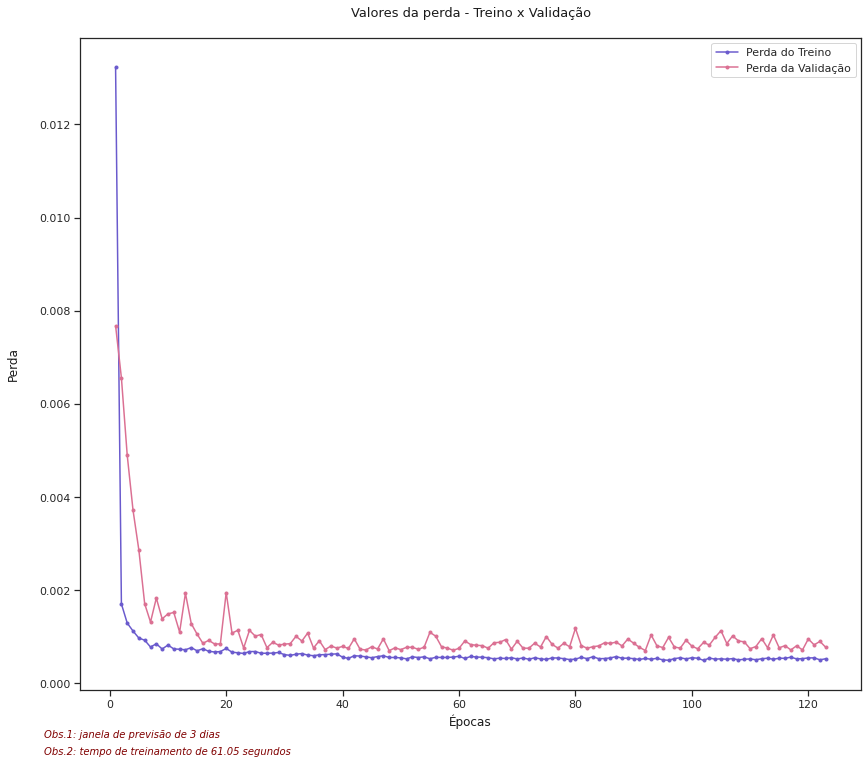

In [ ]:
# Plotando os gráficos das perdas:
plot_train_val_loss (history, time_lstm, path_fig)

In [ ]:
# Criando a lista com o nome dos arquivos LSTM
arquivos_hdf5 = listaArquivos (LSTM_keras_path, ext='.hdf5')
# Criando a lista com o nome dos arquivos LSTM
df_arqs_LSTM = pd.DataFrame(arquivos_hdf5).transpose()
df_arqs_LSTM.columns = ['caminhos', 'nomes_arqs', 'caminhos_nomes_arqs']
# Ordenando o dataframe com o nome dos arquivos em ordem decrescente:
df_ordenado = ordenando_df_lstm(df_arqs_LSTM)

In [ ]:
# Recuperando o "melhor modelo" Keras:
model_LSTM_2 = load_model(df_ordenado['caminhos_nomes_arqs'][0])
print(f"\nNome arquivo do modelo Keras recuperado: {df_ordenado['nomes_arqs'][0]}")

# Previsão para o "melhor modelo":
forecast = model_LSTM_2.predict(X_test, verbose=0)
forecast_copies = np.repeat(forecast, df_lstm.shape[1], axis=-1)
y_pred_new = scaler.inverse_transform(forecast_copies)[:, 0]

# Verificando as métricas:
lstm_result_new = validation (df_new.iloc[-len_test:,0].values, y_pred_new)

# Tempo de treinamento:
print(f"Tempo de treinamento (em segundos): {round(time_lstm,2)}") 


Nome arquivo do modelo Keras recuperado: LSTM_2_081_keras_model.hdf5


Validação do modelo por métricas estatísticas:
Raiz do Erro Quadrático Médio (RMSE) = 0.1317 
Erro Absoluto Médio (MAE) = 0.1038 
Correlação de Pearson (corr) = 0.9727 
Tempo de treinamento (em segundos): 61.05


In [ ]:
# Métricas do melhor modelo:
RMSE_LSTM_2 = lstm_result_new['RMSE']
MAE_LSTM_2 = lstm_result_new['MAE']
corr_LSTM_2 = lstm_result_new['corr']
tempo_treino_LSTM_2 = time_lstm

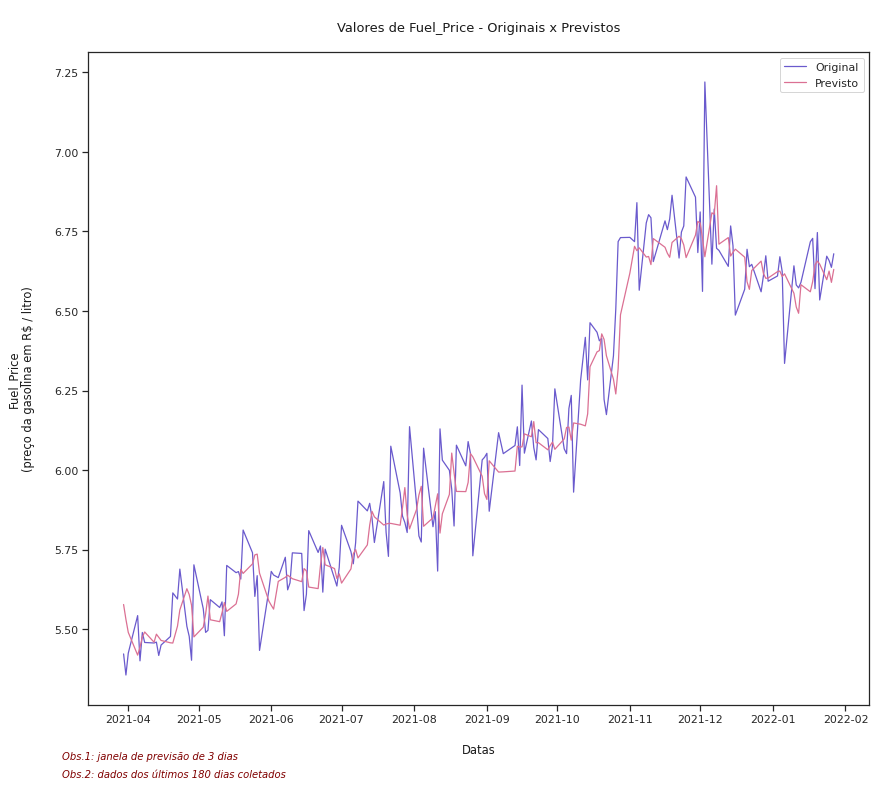

In [ ]:
# Plotando o gráfico da previsão:
plot_predict (past, df_lstm_dates, df_new, len_test,y_pred_new, path_fig)

In [ ]:
# Atualizando dataframe de métricas:
df_all_metrics.loc[index_all_metrics] = [f'LSTM_2',
                                         RMSE_LSTM_2,
                                         MAE_LSTM_2,
                                         corr_LSTM_2,
                                         round(tempo_treino_LSTM_2,2)] 
index_all_metrics += 1
df_all_metrics

,MODELO,RMSE,MAE,corr,Tempo_Processamento
0,ARIMA_1,0.122246,0.091244,0.990621,804.27
1,ARIMA_2,0.122158,0.091162,0.990630,996.20
2,VAR_1,0.123234,0.090607,0.990291,8.50
3,VAR_2,0.122975,0.090667,0.990388,4.26
4,LSTM_1,0.160811,0.126215,0.972672,50.25
5,LSTM_2,0.131684,0.103806,0.972718,61.05


In [ ]:
# Atualizando o dataframe de predições:
df_ypred.loc[:,'y_LSTM_2'] = y_pred_new
df_ypred.head()

,DATAS,y_REAL,y_ARIMA_1,y_ARIMA_2,y_VAR_1,y_VAR_2,y_LSTM_1,y_LSTM_2
0,2021-01-26,4.786904,4.617979,4.624590,4.640301,4.628515,4.670801,4.638906
1,2021-01-27,4.627419,4.633419,4.632962,4.655449,4.657515,4.701144,4.677330
2,2021-01-28,4.533405,4.639840,4.632933,4.670426,4.651163,4.745069,4.712239
3,2021-02-01,4.849375,4.644449,4.645650,4.640620,4.651114,4.742723,4.694545
4,2021-02-02,4.778471,4.673378,4.678649,4.675744,4.691742,4.701520,4.672906


In [ ]:
# Salvando os dataframes com as predições e métricas:
salva_dataframe(df_all_metrics, path_backup_df+'df_all_metrics')
salva_dataframe(df_ypred, path_backup_df+'df_ypred')

In [ ]:
# Alterando os arquivos LSTM de pasta:
for kk, ww  in zip(df_ordenado['nomes_arqs'],
                   df_ordenado['caminhos_nomes_arqs']):
  old_name = ww # Nome/pasta antiga
  new_name = keras_moved_files_path + kk # Nome/pasta nova
  time.sleep(1)
  # Alterando o diretório/nomes dos arquivos dos modelos:
  os.replace(old_name, new_name)

In [ ]:
# Definindo a lista de argumentos de entrada para a função de loop:
tf.keras.backend.clear_session() # Clear model
epocas= 250 # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda,
                  epocas, mini_lote]
print('Lista com os hiper parâmetros de teste:')
print('[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, ')
print(' dropout_rate, otimizador, perda, epocas, mini_lote]:')
print(hiper_par_list)

Lista com os hiper parâmetros de teste:
[tot_loops, janela, LSTM_units_1, LSTM_units_2, ativacao, 
 dropout_rate, otimizador, perda, epocas, mini_lote]:
[15, 3, 64, 32, 'tanh', 0.18, 'adam', 'mse', 250, 32]


In [ ]:
# Calculando as métricas médias e atualizando o dataframe de métricas:
(mean_RMSE,
 mean_MAE, 
 mean_corr,
 mean_tempo_treino,
 mean_epocas) = calc_keras_mean (hiper_par_list,
                                 X_train, y_train,
                                 X_validation, y_validation,
                                 X_test, y_test,
                                 keras_mean_path,
                                 keras_moved_files_path)


Iteração 1 de 15... em 0.00 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_038_keras_model.hdf5
Iteração 2 de 15... em 0.99 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_101_keras_model.hdf5
Iteração 3 de 15... em 2.81 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_127_keras_model.hdf5
Iteração 4 de 15... em 4.40 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_057_keras_model.hdf5
Iteração 5 de 15... em 6.11 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_166_keras_model.hdf5
Iteração 6 de 15... em 7.84 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_067_keras_model.hdf5
Iteração 7 de 15... em 9.49 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_103_keras_model.hdf5
Iteração 8 de 15... em 11.18 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_056_keras_model.hdf5
Iteração 9 de 15... em 12.30 minutos...

Nome arquivo do modelo Keras recuperado: MEAN_X_036_keras_model.hdf5
Iteração 10 de 15

In [ ]:
# Ajustando a lista de hiper parâmetros:
epocas = mean_epocas # Número de épocas (epochs)
hiper_par_list = [tot_loops, janela, LSTM_units_1, LSTM_units_2,
                  ativacao, dropout_rate, otimizador, perda, epocas,
                  mini_lote]

# Atualizando df_metricas: 
df_metricas = atualiza_df_metricas(hiper_par_list,
                                   df_metricas,
                                   mean_RMSE,
                                   mean_MAE, 
                                   mean_corr,
                                   mean_tempo_treino)

# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

df_metricas

,Épocas,Tam_Mini_Batch,Janela,Unidades_Camada_1,Unidades_Camada_2,Ativação,Dropout,Otimizador,Perda,RMSE_Medio,MAE_Medio,corr_Medio,Tmp_Medio_Tr
0,155.27,32,3,64,32,tanh,0.18,adam,mse,0.137210,0.107032,0.972581,56.119641
1,149.33,32,3,64,32,tanh,0.18,adam,mse,0.169127,0.135355,0.973136,55.239115
2,75,32,15,64,32,tanh,0.18,adam,mse,0.263660,0.221104,0.971693,75.827589
3,75,32,7,64,32,tanh,0.18,adam,mse,0.245084,0.201633,0.972295,55.985960
4,75,32,3,32,0,tanh,0.18,adam,mse,0.148039,0.115877,0.972901,19.764344
5,75,32,3,64,0,tanh,0.18,adam,mse,0.156620,0.124056,0.973313,20.875826
6,75,32,3,32,16,tanh,0.18,adam,mse,0.161075,0.128079,0.972751,32.412383
7,75,32,3,64,32,tanh,0.18,adam,mse,0.140814,0.109190,0.973286,34.995897
8,75,32,3,64,32,tanh,0.25,adam,mse,0.140887,0.108780,0.973213,33.084652
9,75,32,3,64,32,tanh,0.15,adam,mse,0.149347,0.116903,0.973251,36.008309


In [ ]:
# Salvando df_metricas:
salva_dataframe(df_metricas, arquivo_df_metricas)

# **FIM**